In [ ]:
# install required packages
!pip install aif360
!pip install aix360
!pip install fairlearn
!pip install lime

In [2]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
#import matplotlib as plt
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']= 300
import numpy as np
from IPython.display import Markdown, display

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import MinMaxScaler

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover

# LIME
from aif360.datasets.lime_encoder import LimeEncoder
import lime
from lime.lime_tabular import LimeTabularExplainer

np.random.seed(1)

### Load data & create splits for training/validating/testing model  

In [23]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os

import pandas as pd

from aif360.datasets import StandardDataset


class WFTRAIN(StandardDataset):

    def __init__(self, label_name='goodbad', favorable_classes=['Bad'],
                 protected_attribute_names=['card_age'],
                 privileged_classes=[lambda x: x >= 261],
                 instance_weights_name=None,
                 categorical_features=[],
                 features_to_keep=['avg_card_debt','card_age','non_mtg_acc_past_due_12_months_num',
                                   'inq_12_month_num','uti_card'], 
                 features_to_drop=["Default_ind"],
                 na_values=["unknown"], custom_preprocessing=None,
                 metadata=None):
        """See :obj:`StandardDataset` for a description of the arguments.
        By default, this code converts the 'card_age' attribute to a binary value
        where privileged is `card_age >= 261` and unprivileged is `card_age < 261`
        """

        filepath = 'https://raw.githubusercontent.com/KushajveerSingh/ds_cup/main/processed_data/tr_bal.csv'

        try:
            df = pd.read_csv(filepath, sep=',', na_values=na_values)

        except IOError as err:
              print("IOError: {}".format(err))
              print("To use this class, please download the data set:")
              import sys
              sys.exit(1)

        super(WFTRAIN, self).__init__(df=df, label_name=label_name,
            favorable_classes=favorable_classes,
            protected_attribute_names=protected_attribute_names,
            privileged_classes=privileged_classes,
            instance_weights_name=instance_weights_name,
            categorical_features=categorical_features,
            features_to_keep=features_to_keep,
            features_to_drop=features_to_drop, na_values=na_values,
            custom_preprocessing=custom_preprocessing, metadata=metadata)       


class WFVALID(StandardDataset):

    def __init__(self, label_name='goodbad', favorable_classes=['Bad'],
                 protected_attribute_names=['card_age'],
                 privileged_classes=[lambda x: x >= 251],
                 instance_weights_name=None,
                 categorical_features=[],
                 features_to_keep=['avg_card_debt','card_age','non_mtg_acc_past_due_12_months_num',
                                   'inq_12_month_num','uti_card'],
                  features_to_drop=["Default_ind"],
                 na_values=["unknown"], custom_preprocessing=None,
                 metadata=None):
        """See :obj:`StandardDataset` for a description of the arguments.
        By default, this code converts the 'card_age' attribute to a binary value
        where privileged is `card_age >= 251` and unprivileged is `card_age < 251`
        """

        filepath = 'https://raw.githubusercontent.com/KushajveerSingh/ds_cup/main/processed_data/valid.csv'

        try:
            df = pd.read_csv(filepath, sep=',', na_values=na_values)
        except IOError as err:
            print("IOError: {}".format(err))
            print("To use this class, please download the data set:")
            import sys
            sys.exit(1)

        super(WFVALID, self).__init__(df=df, label_name=label_name,
            favorable_classes=favorable_classes,
            protected_attribute_names=protected_attribute_names,
            privileged_classes=privileged_classes,
            instance_weights_name=instance_weights_name,
            categorical_features=categorical_features,
            features_to_keep=features_to_keep,
            features_to_drop=features_to_drop, na_values=na_values,
            custom_preprocessing=custom_preprocessing, metadata=metadata) 
        
class WFTEST(StandardDataset):

    def __init__(self, label_name='goodbad', favorable_classes=['Bad'],
                 protected_attribute_names=['card_age'],
                 privileged_classes=[lambda x: x >= 269],
                 instance_weights_name=None,
                 categorical_features=[],
                 features_to_keep=['avg_card_debt','card_age','non_mtg_acc_past_due_12_months_num',
                                   'inq_12_month_num','uti_card'],
                  features_to_drop=["Default_ind"],
                 na_values=["unknown"], custom_preprocessing=None,
                 metadata=None):
        """See :obj:`StandardDataset` for a description of the arguments.
        By default, this code converts the 'card_age' attribute to a binary value
        where privileged is `card_age >= 269` and unprivileged is `card_age < 269`
        """

        filepath = 'https://raw.githubusercontent.com/KushajveerSingh/ds_cup/main/processed_data/test.csv'

        try:
            df = pd.read_csv(filepath, sep=',', na_values=na_values)
        except IOError as err:
            print("IOError: {}".format(err))
            print("To use this class, please download the data set:")
            import sys
            sys.exit(1)

        super(WFTEST, self).__init__(df=df, label_name=label_name,
            favorable_classes=favorable_classes,
            protected_attribute_names=protected_attribute_names,
            privileged_classes=privileged_classes,
            instance_weights_name=instance_weights_name,
            categorical_features=categorical_features,
            features_to_keep=features_to_keep,
            features_to_drop=features_to_drop, na_values=na_values,
            custom_preprocessing=custom_preprocessing, metadata=metadata) 

In [5]:
# create datasets
dataset_orig_train = WFTRAIN()
dataset_orig_val = WFVALID()
dataset_orig_test = WFTEST()

sens_ind = 0
sens_attr = dataset_orig_train.protected_attribute_names[sens_ind]

unprivileged_groups = [{sens_attr: v} for v in
                       dataset_orig_train.unprivileged_protected_attributes[sens_ind]]
privileged_groups = [{sens_attr: v} for v in
                     dataset_orig_train.privileged_protected_attributes[sens_ind]]

This function will be used throughout the notebook to print out some labels, names, etc.

In [6]:
def describe(train=None, val=None, test=None):
    if train is not None:
        display(Markdown("#### Training Dataset shape"))
        print(train.features.shape)
    if val is not None:
        display(Markdown("#### Validation Dataset shape"))
        print(val.features.shape)
    display(Markdown("#### Test Dataset shape"))
    print(test.features.shape)
    display(Markdown("#### Favorable and unfavorable labels"))
    print(test.favorable_label, test.unfavorable_label)
    display(Markdown("#### Protected attribute names"))
    print(test.protected_attribute_names)
    display(Markdown("#### Privileged and unprivileged protected attribute values"))
    print(test.privileged_protected_attributes, 
          test.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(test.feature_names)

Train, Validation and Test datasets details

In [8]:
describe(dataset_orig_train, dataset_orig_val, dataset_orig_test)

#### Training Dataset shape

(3172, 5)


#### Validation Dataset shape

(3000, 5)


#### Test Dataset shape

(5000, 5)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['card_age']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['avg_card_debt', 'card_age', 'non_mtg_acc_past_due_12_months_num', 'inq_12_month_num', 'uti_card']


Metrics for original data

In [11]:
metric_orig_train = BinaryLabelDatasetMetric(
        dataset_orig_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_orig_train = MetricTextExplainer(metric_orig_train)

print(explainer_orig_train.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.3777218290691344


### Learning a Logistic Regression (LR) classifier on original data

#### Training LR model on original data

In [12]:
dataset = dataset_orig_train
model = make_pipeline(MinMaxScaler(),
                      LogisticRegression(penalty='none'))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}

lr_orig = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

Returning the estimated coefficients in this order:  
['avg_card_debt', 'card_age', 'non_mtg_acc_past_due_12_months_num', 'inq_12_month_num', 'uti_card']

In [13]:
print(lr_orig.named_steps.logisticregression.coef_)

[[ 2.75723518 -0.74994343  7.52140667  1.32437101  5.52673679]]


Returning the intercept

In [14]:
print(lr_orig.named_steps.logisticregression.intercept_)

[-3.42002044]


#### Validating LR model on original data

This function will be used throughout the tutorial to find best threshold using a validation set

In [15]:
from collections import defaultdict

def test(dataset, model, thresh_arr):
    try:
        # sklearn classifier
        y_val_pred_prob = model.predict_proba(dataset.features)
        pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    except AttributeError:
        # aif360 inprocessing algorithm
        y_val_pred_prob = model.predict(dataset).scores
        pos_ind = 0
    
    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
                dataset, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2)
        metric_arrs['sensitivity'].append(metric.true_positive_rate())
        metric_arrs['specificity'].append(metric.true_negative_rate())
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['theil_ind'].append(metric.theil_index())
    
    return metric_arrs

In [16]:
# finding the best threshold
thresh_arr = np.linspace(0.2, 0.9, 100)
val_metrics = test(dataset=dataset_orig_val,
                   model=lr_orig,
                   thresh_arr=thresh_arr)
lr_orig_best_ind = np.argmax(val_metrics['bal_acc'])

Plot metrics with twin x-axes

In [17]:
def plot(x, x_name, y_left, y_left_name, y_right, y_right_name):
    fig, ax1 = plt.subplots(figsize=(10,7))
    ax1.plot(x, y_left)
    ax1.set_xlabel(x_name, fontsize=16, fontweight='bold')
    ax1.set_ylabel(y_left_name, color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    ax1.set_ylim(0.5, 0.99)

    ax2 = ax1.twinx()
    ax2.plot(x, y_right, color='r')
    ax2.set_ylabel(y_right_name, color='r', fontsize=16, fontweight='bold')
    if 'DI' in y_right_name:
        ax2.set_ylim(0., 0.99)
    else:
        ax2.set_ylim(-0.25, 0.3)

    best_ind = np.argmax(y_left)
    ax2.axvline(np.array(x)[best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)

Here we plot $1 - \min(\text{disparate impact}, 1/\text{disparate impact})$ since it's possible to overcorrect and end up with a value greater than 1, implying unfairness for the original privileged group. For shorthand, we simply call this 1-min(DI, 1/DI) from now on. We want the plotted metric to be less than 0.2.

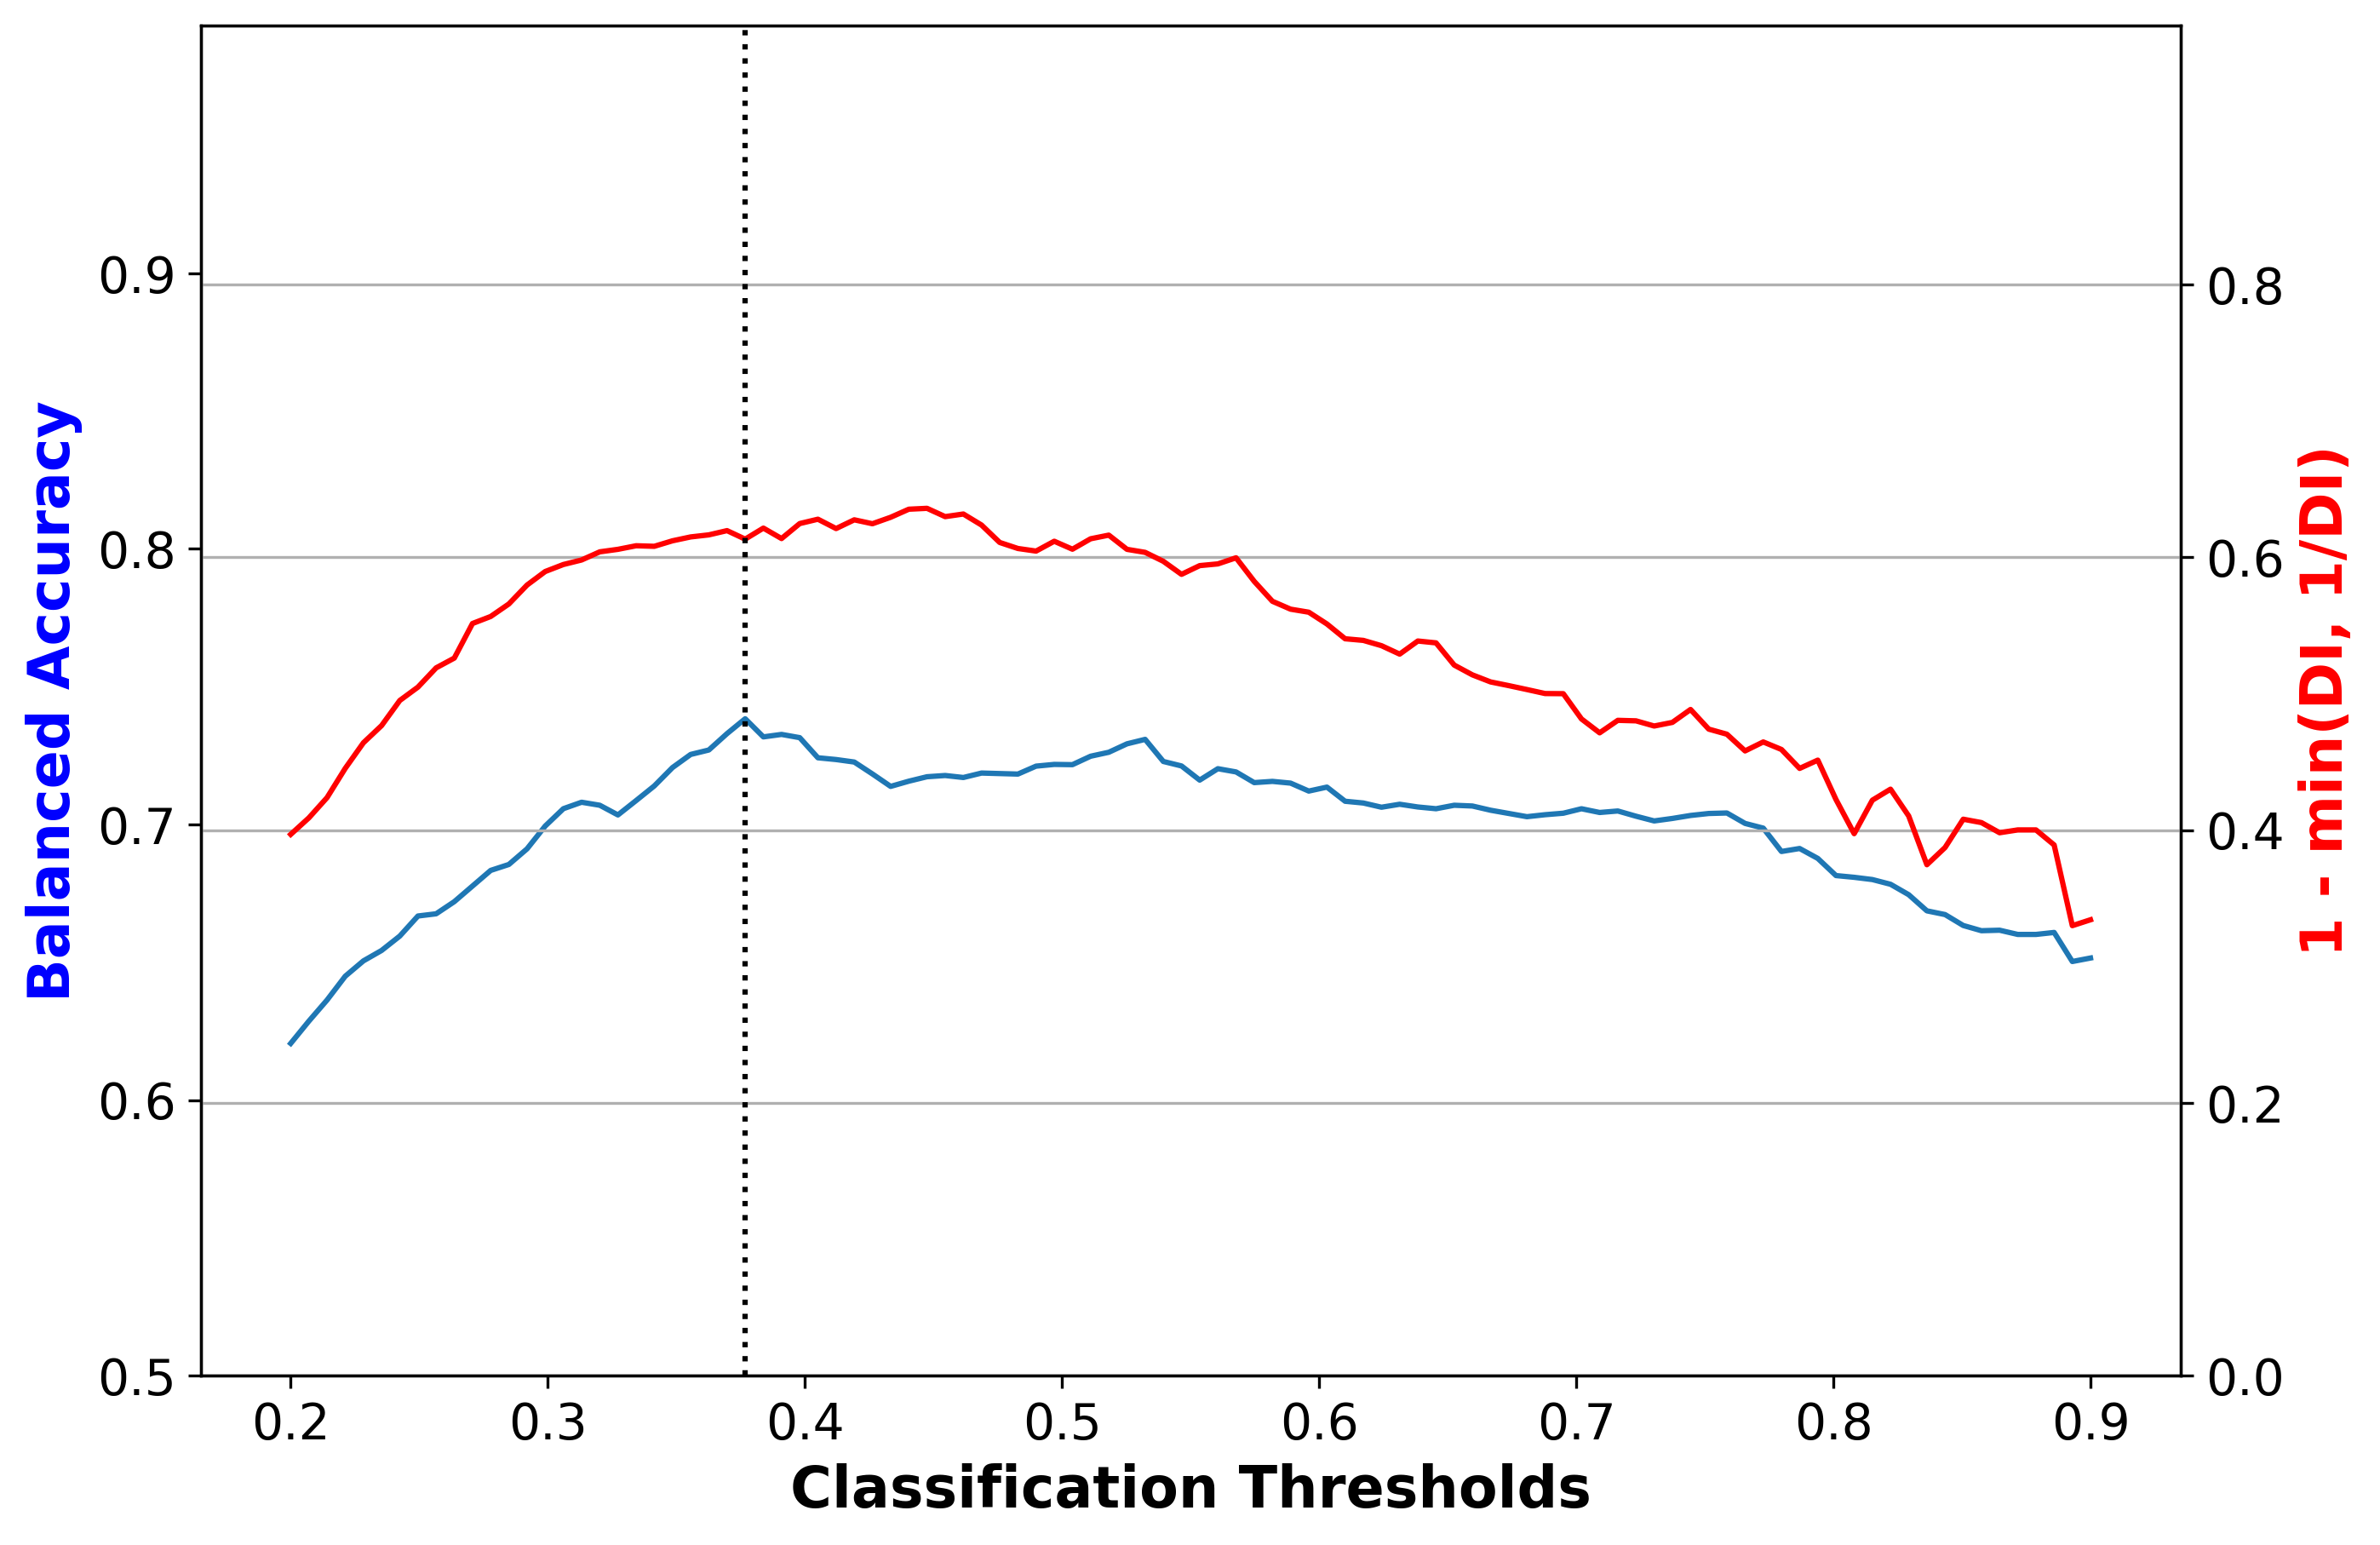

In [18]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

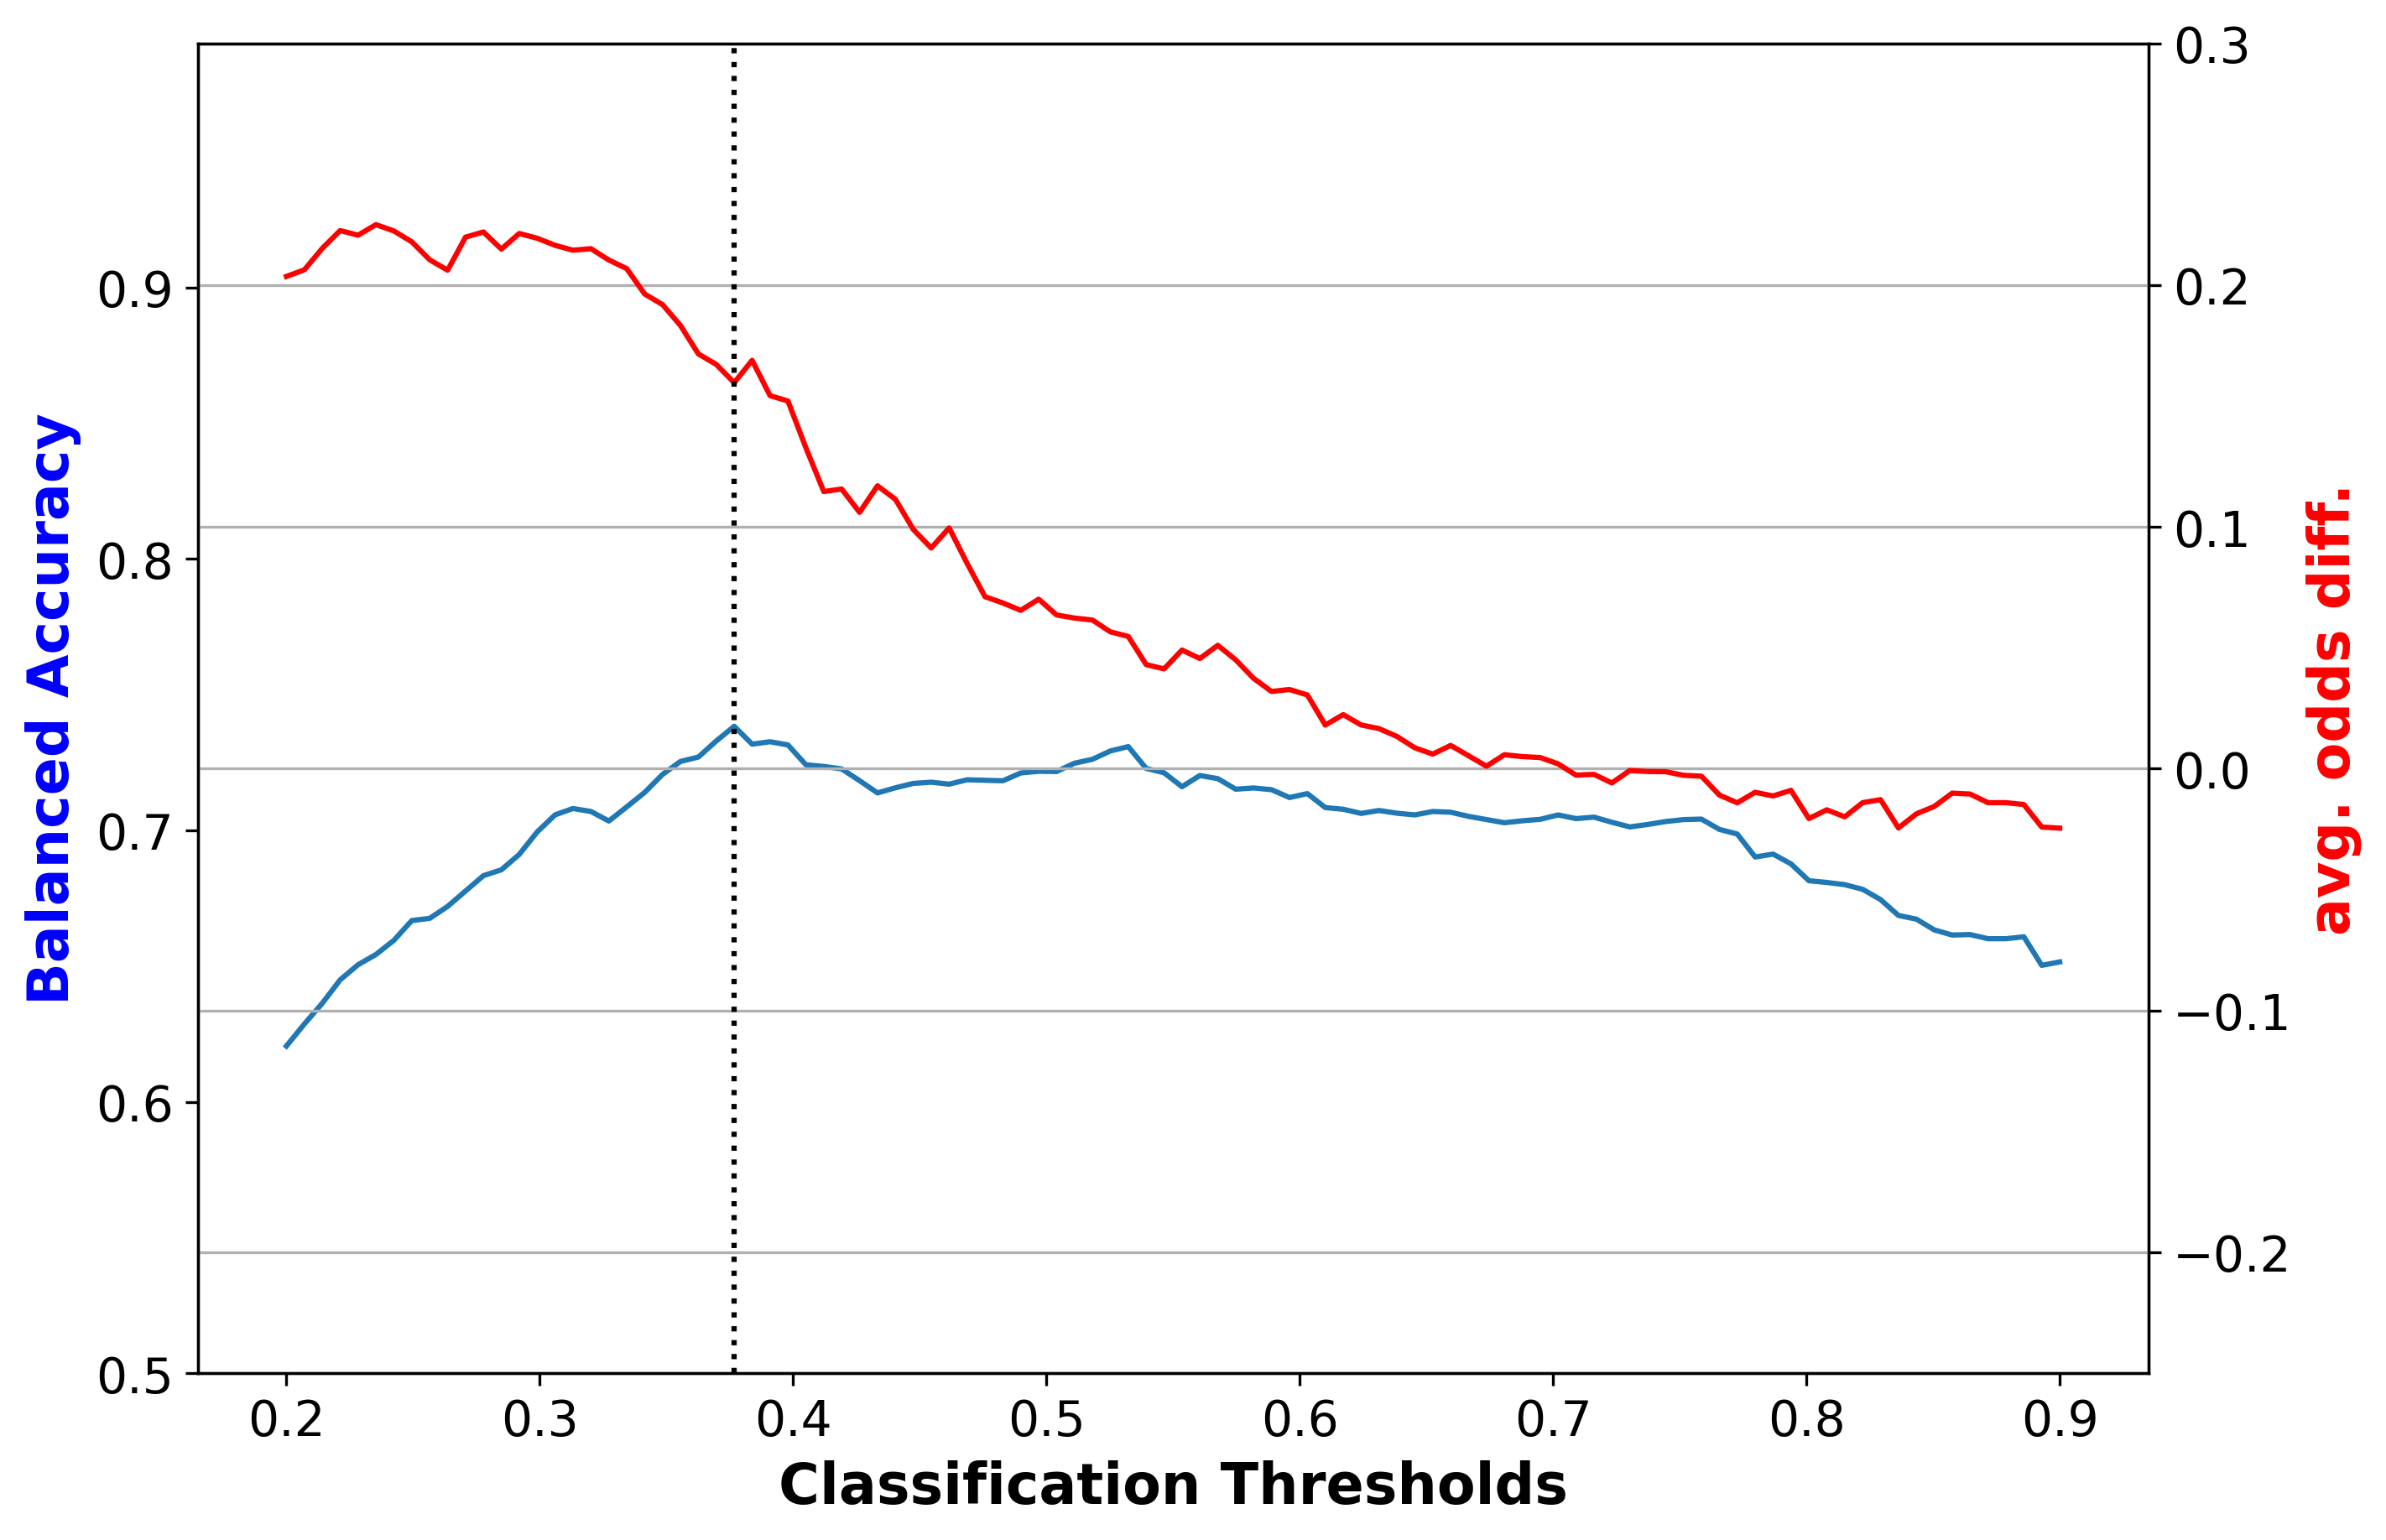

In [19]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

Make a function to print out accuracy and fairness metrics.

In [20]:
def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
    print("Sensitivity: {:6.4f}".format(metrics['sensitivity'][best_ind]))
    print("Specificity: {:6.4f}".format(metrics['specificity'][best_ind]))
    disp_imp_at_best_ind = 1 - min(metrics['disp_imp'][best_ind], 1/metrics['disp_imp'][best_ind])
    print("Corresponding 1-min(DI, 1/DI) value: {:6.4f}".format(disp_imp_at_best_ind))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))
    print("Corresponding Theil index value: {:6.4f}".format(metrics['theil_ind'][best_ind]))

In [21]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.3768
Best balanced accuracy: 0.7384
Sensitivity: 0.7838
Specificity: 0.6929
Corresponding 1-min(DI, 1/DI) value: 0.6133
Corresponding average odds difference value: 0.1597
Corresponding statistical parity difference value: 0.3040
Corresponding equal opportunity difference value: 0.0137
Corresponding Theil index value: 0.0731


#### Testing LR model on original data

In [22]:
lr_orig_metrics = test(dataset=dataset_orig_test,
                       model=lr_orig,
                       thresh_arr=[thresh_arr[lr_orig_best_ind]])

In [24]:
describe_metrics(lr_orig_metrics, [thresh_arr[lr_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.3768
Best balanced accuracy: 0.7126
Sensitivity: 0.8229
Specificity: 0.6023
Corresponding 1-min(DI, 1/DI) value: 0.5837
Corresponding average odds difference value: 0.2584
Corresponding statistical parity difference value: 0.3562
Corresponding equal opportunity difference value: 0.1645
Corresponding Theil index value: 0.0739


For all the fairness metrics displayed above, the value should be close to '0' for fairness.

1-min(DI, 1/DI) < 0.2 is typically desired for classifier predictions to be fair.

However, for a logistic regression classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.

Similarly, $\text{average odds difference} = \frac{(FPR_{unpriv}-FPR_{priv})+(TPR_{unpriv}-TPR_{priv})}{2}$ must be close to zero for the classifier to be fair.

Again, the results for this classifier-data combination are still high. This still implies unfairness.

### Learning a Random Forest (RF) classifier on original data  

#### Training RF model on original data by bthe best parameters obtained from optimization

In [67]:
dataset = dataset_orig_train
model = make_pipeline(MinMaxScaler(),
                      RandomForestClassifier(bootstrap= True,
                                              criterion= 'entropy',
                                              max_depth= 12,
                                              max_features= 'sqrt',
                                              min_samples_leaf= 5,
                                              min_samples_split= 12,
                                              n_estimators= 1000,
                                             random_state=1))

fit_params = {'randomforestclassifier__sample_weight': dataset.instance_weights}
rf_orig = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

Displaying feature importance

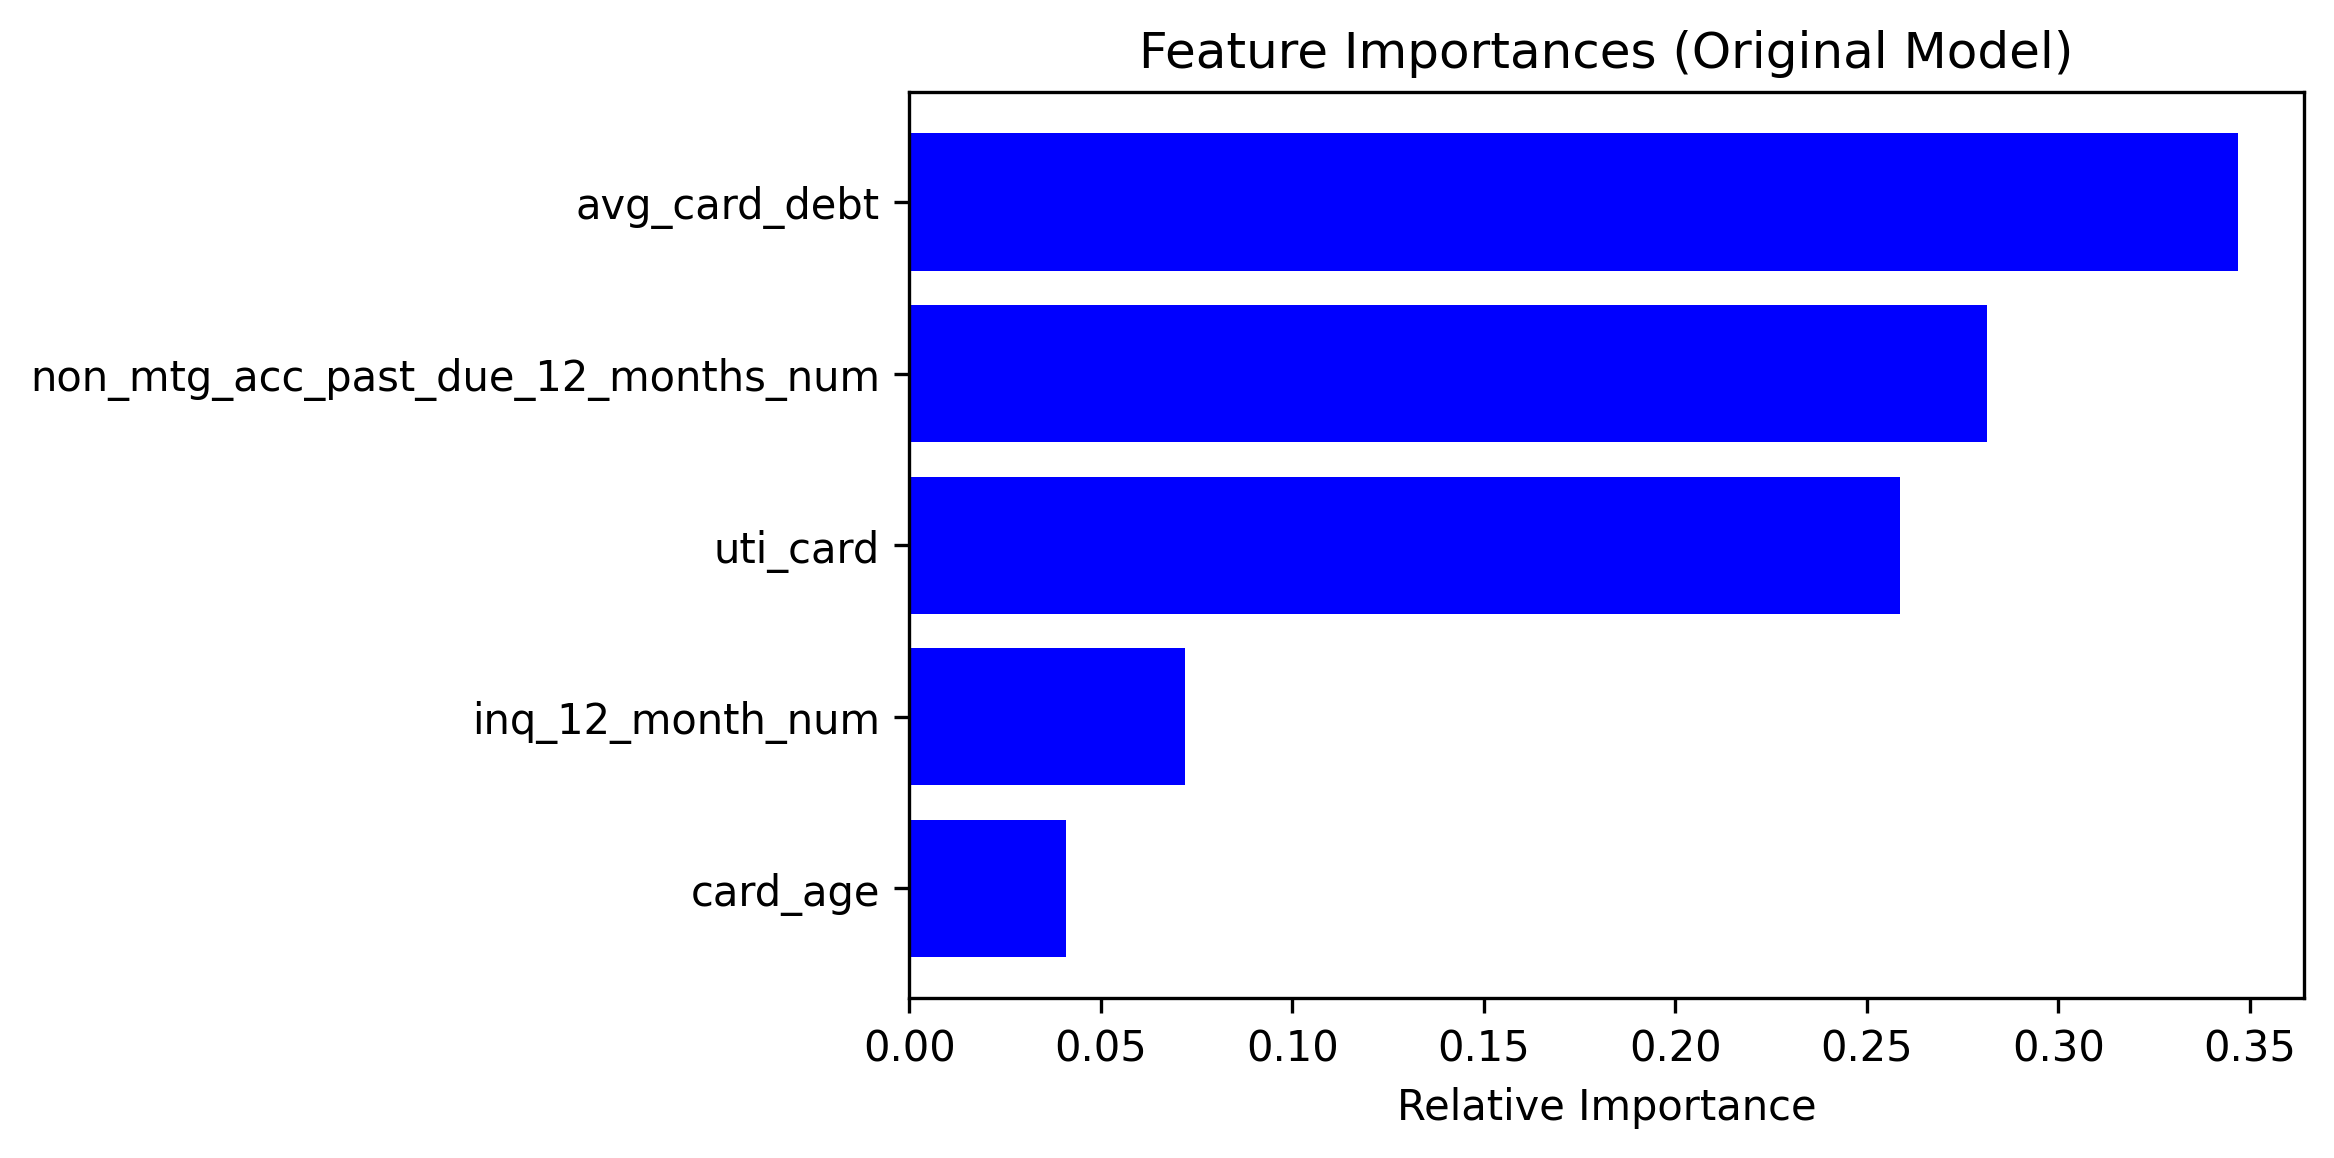

In [26]:
# original model
features = dataset.feature_names
importances = rf_orig.named_steps.randomforestclassifier.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances (Original Model)')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Partial Dependence Plots for the Original Model
If you want to see the PDP plots, run this part.  Otherwise you can skip it.  
(It takes some time to run...)

In [ ]:
from sklearn.inspection import plot_partial_dependence

# individual PDP plots
pdp_01 = plot_partial_dependence(rf_orig, dataset.features, [0,1]) 
pdp_23 = plot_partial_dependence(rf_orig, dataset.features, [2,3]) 
pdp_4 = plot_partial_dependence(rf_orig, dataset.features, [4]) 

# paiwise PDP plots (it takes more time to run)
pdp_01 = plot_partial_dependence(rf_orig, dataset.features, [(0,1)]) 
pdp_02 = plot_partial_dependence(rf_orig, dataset.features, [(0,2)]) 
pdp_03 = plot_partial_dependence(rf_orig, dataset.features, [(0,3)]) 
pdp_04 = plot_partial_dependence(rf_orig, dataset.features, [(0,4)]) 
pdp_12 = plot_partial_dependence(rf_orig, dataset.features, [(1,2)]) 
pdp_13 = plot_partial_dependence(rf_orig, dataset.features, [(1,3)]) 
pdp_14 = plot_partial_dependence(rf_orig, dataset.features, [(1,4)]) 
pdp_23 = plot_partial_dependence(rf_orig, dataset.features, [(2,3)]) 
pdp_24 = plot_partial_dependence(rf_orig, dataset.features, [(2,4)]) 
pdp_34 = plot_partial_dependence(rf_orig, dataset.features, [(3,4)]) 

#### Validating RF model on original data

In [27]:
thresh_arr = np.linspace(0.3, 0.8, 100)
val_metrics = test(dataset=dataset_orig_val,
                   model=rf_orig,
                   thresh_arr=thresh_arr)
rf_orig_best_ind = np.argmax(val_metrics['bal_acc'])

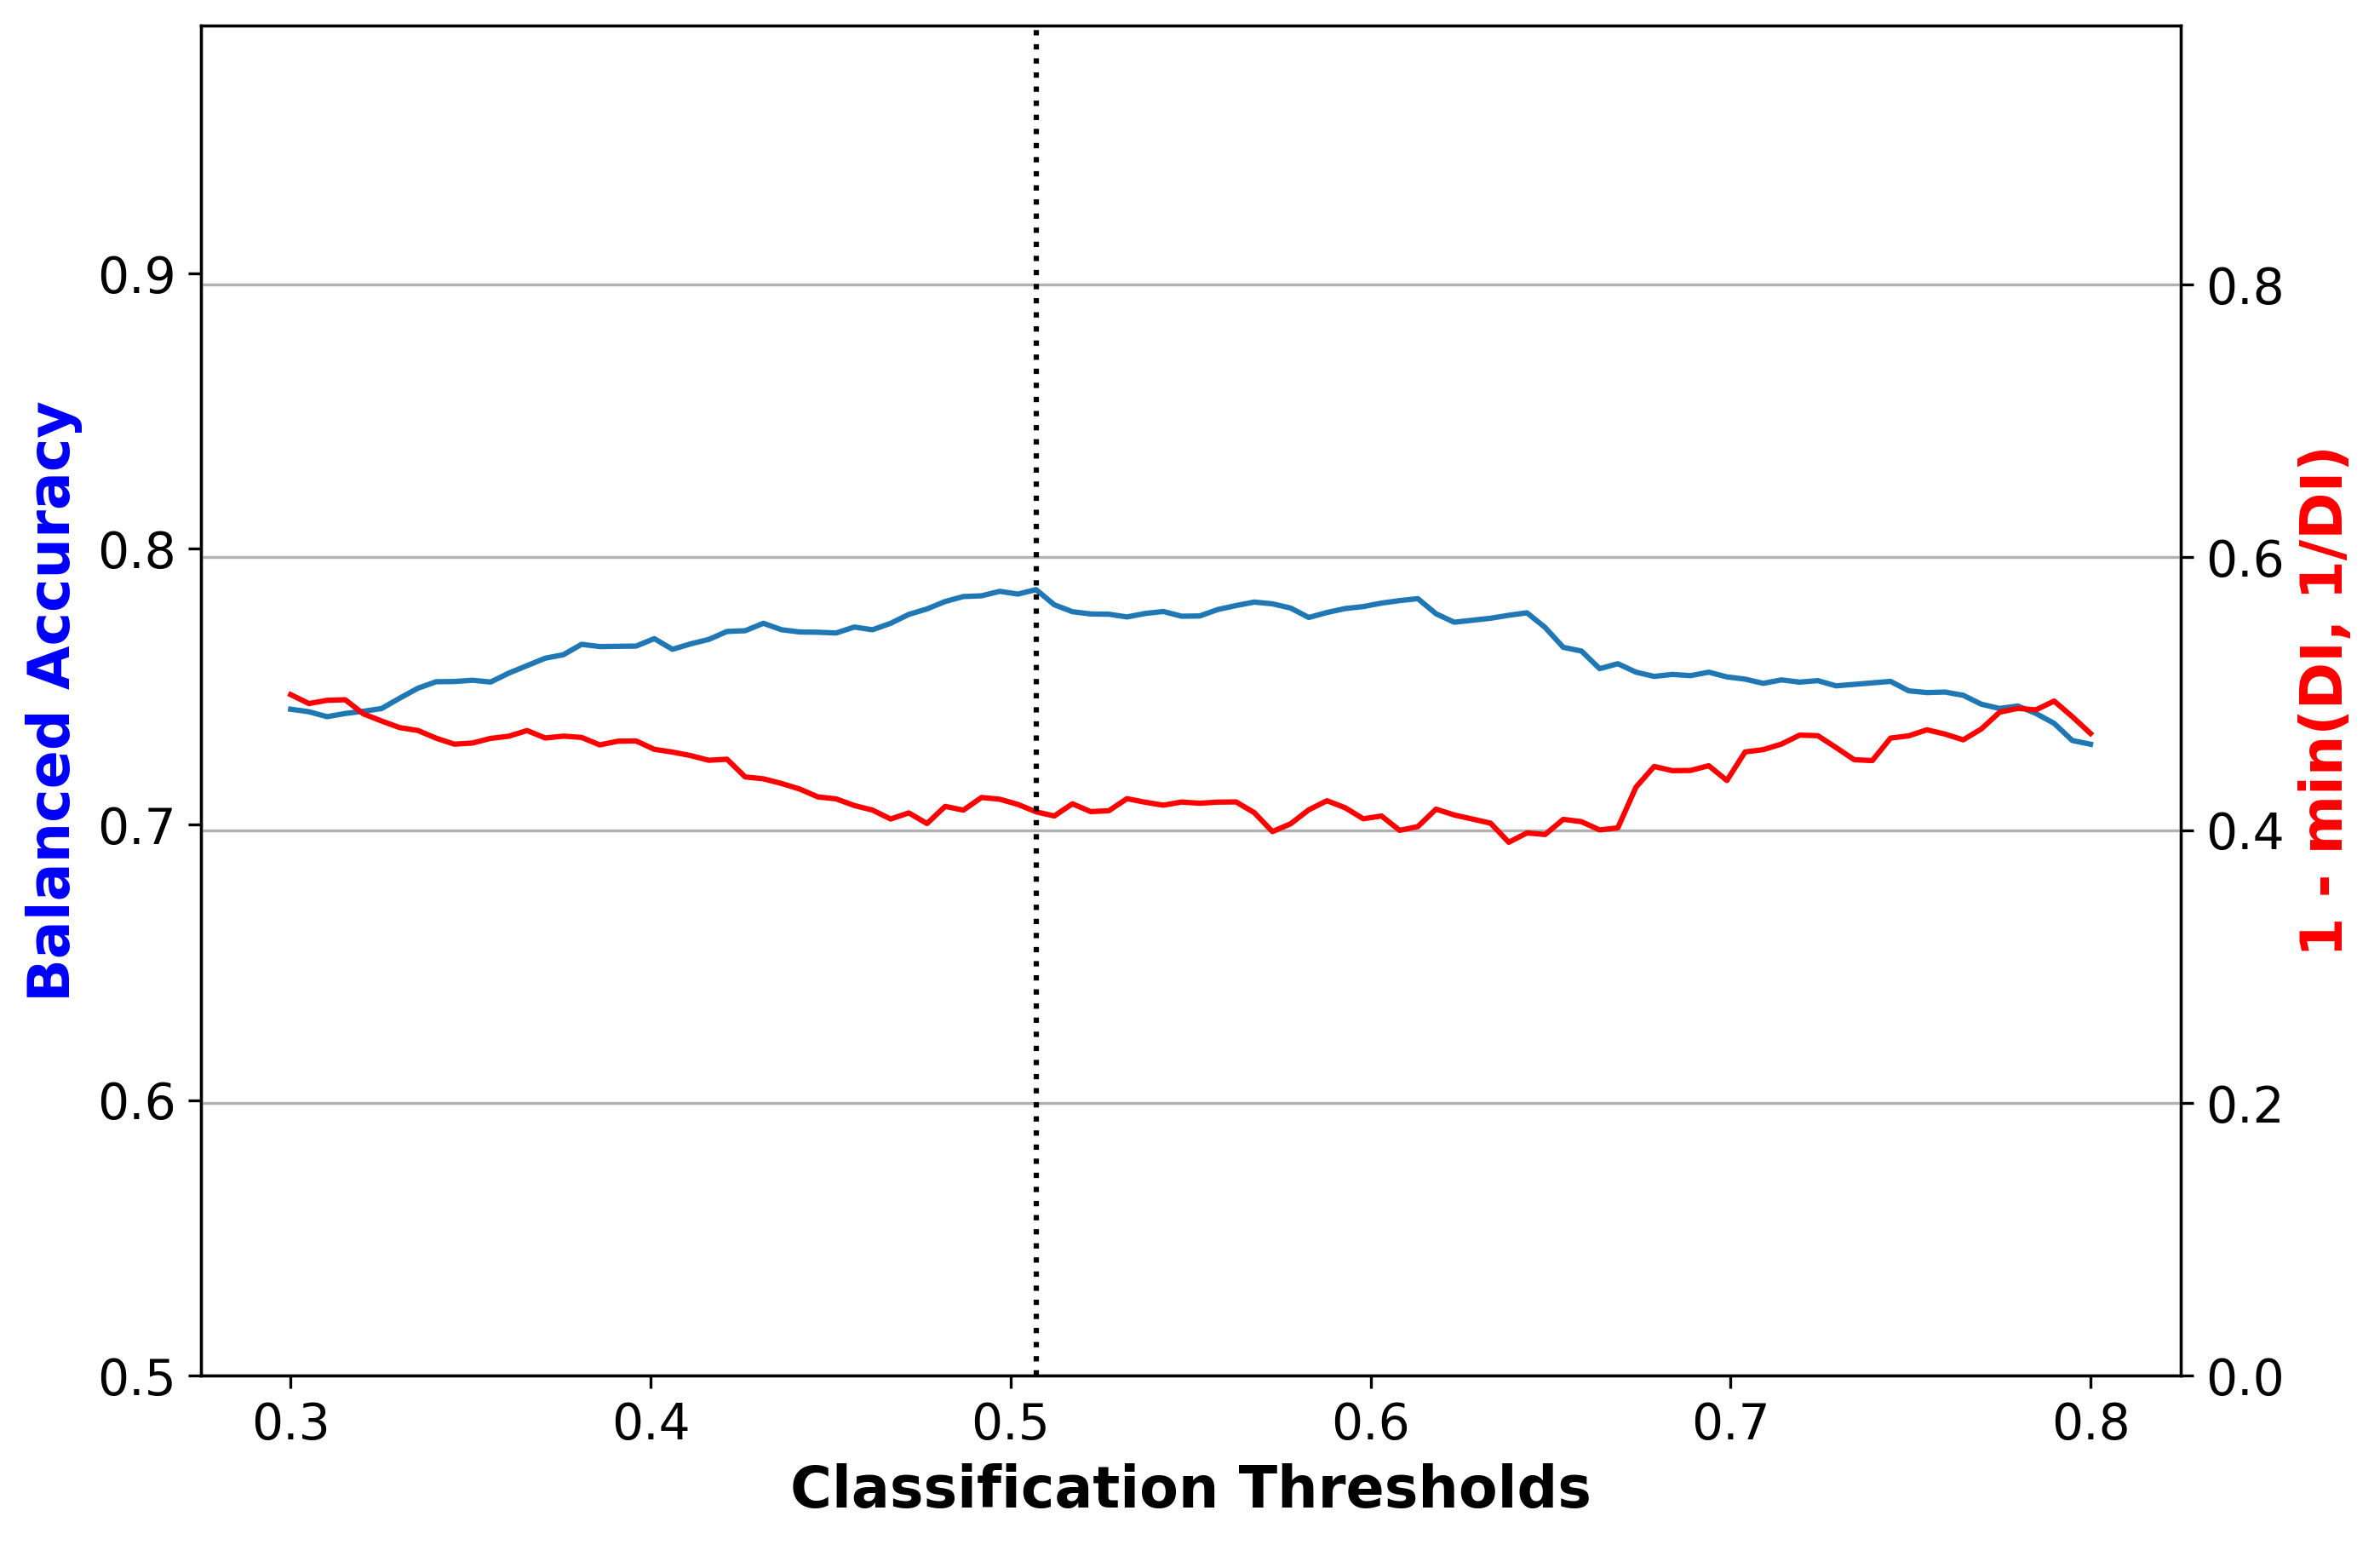

In [28]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

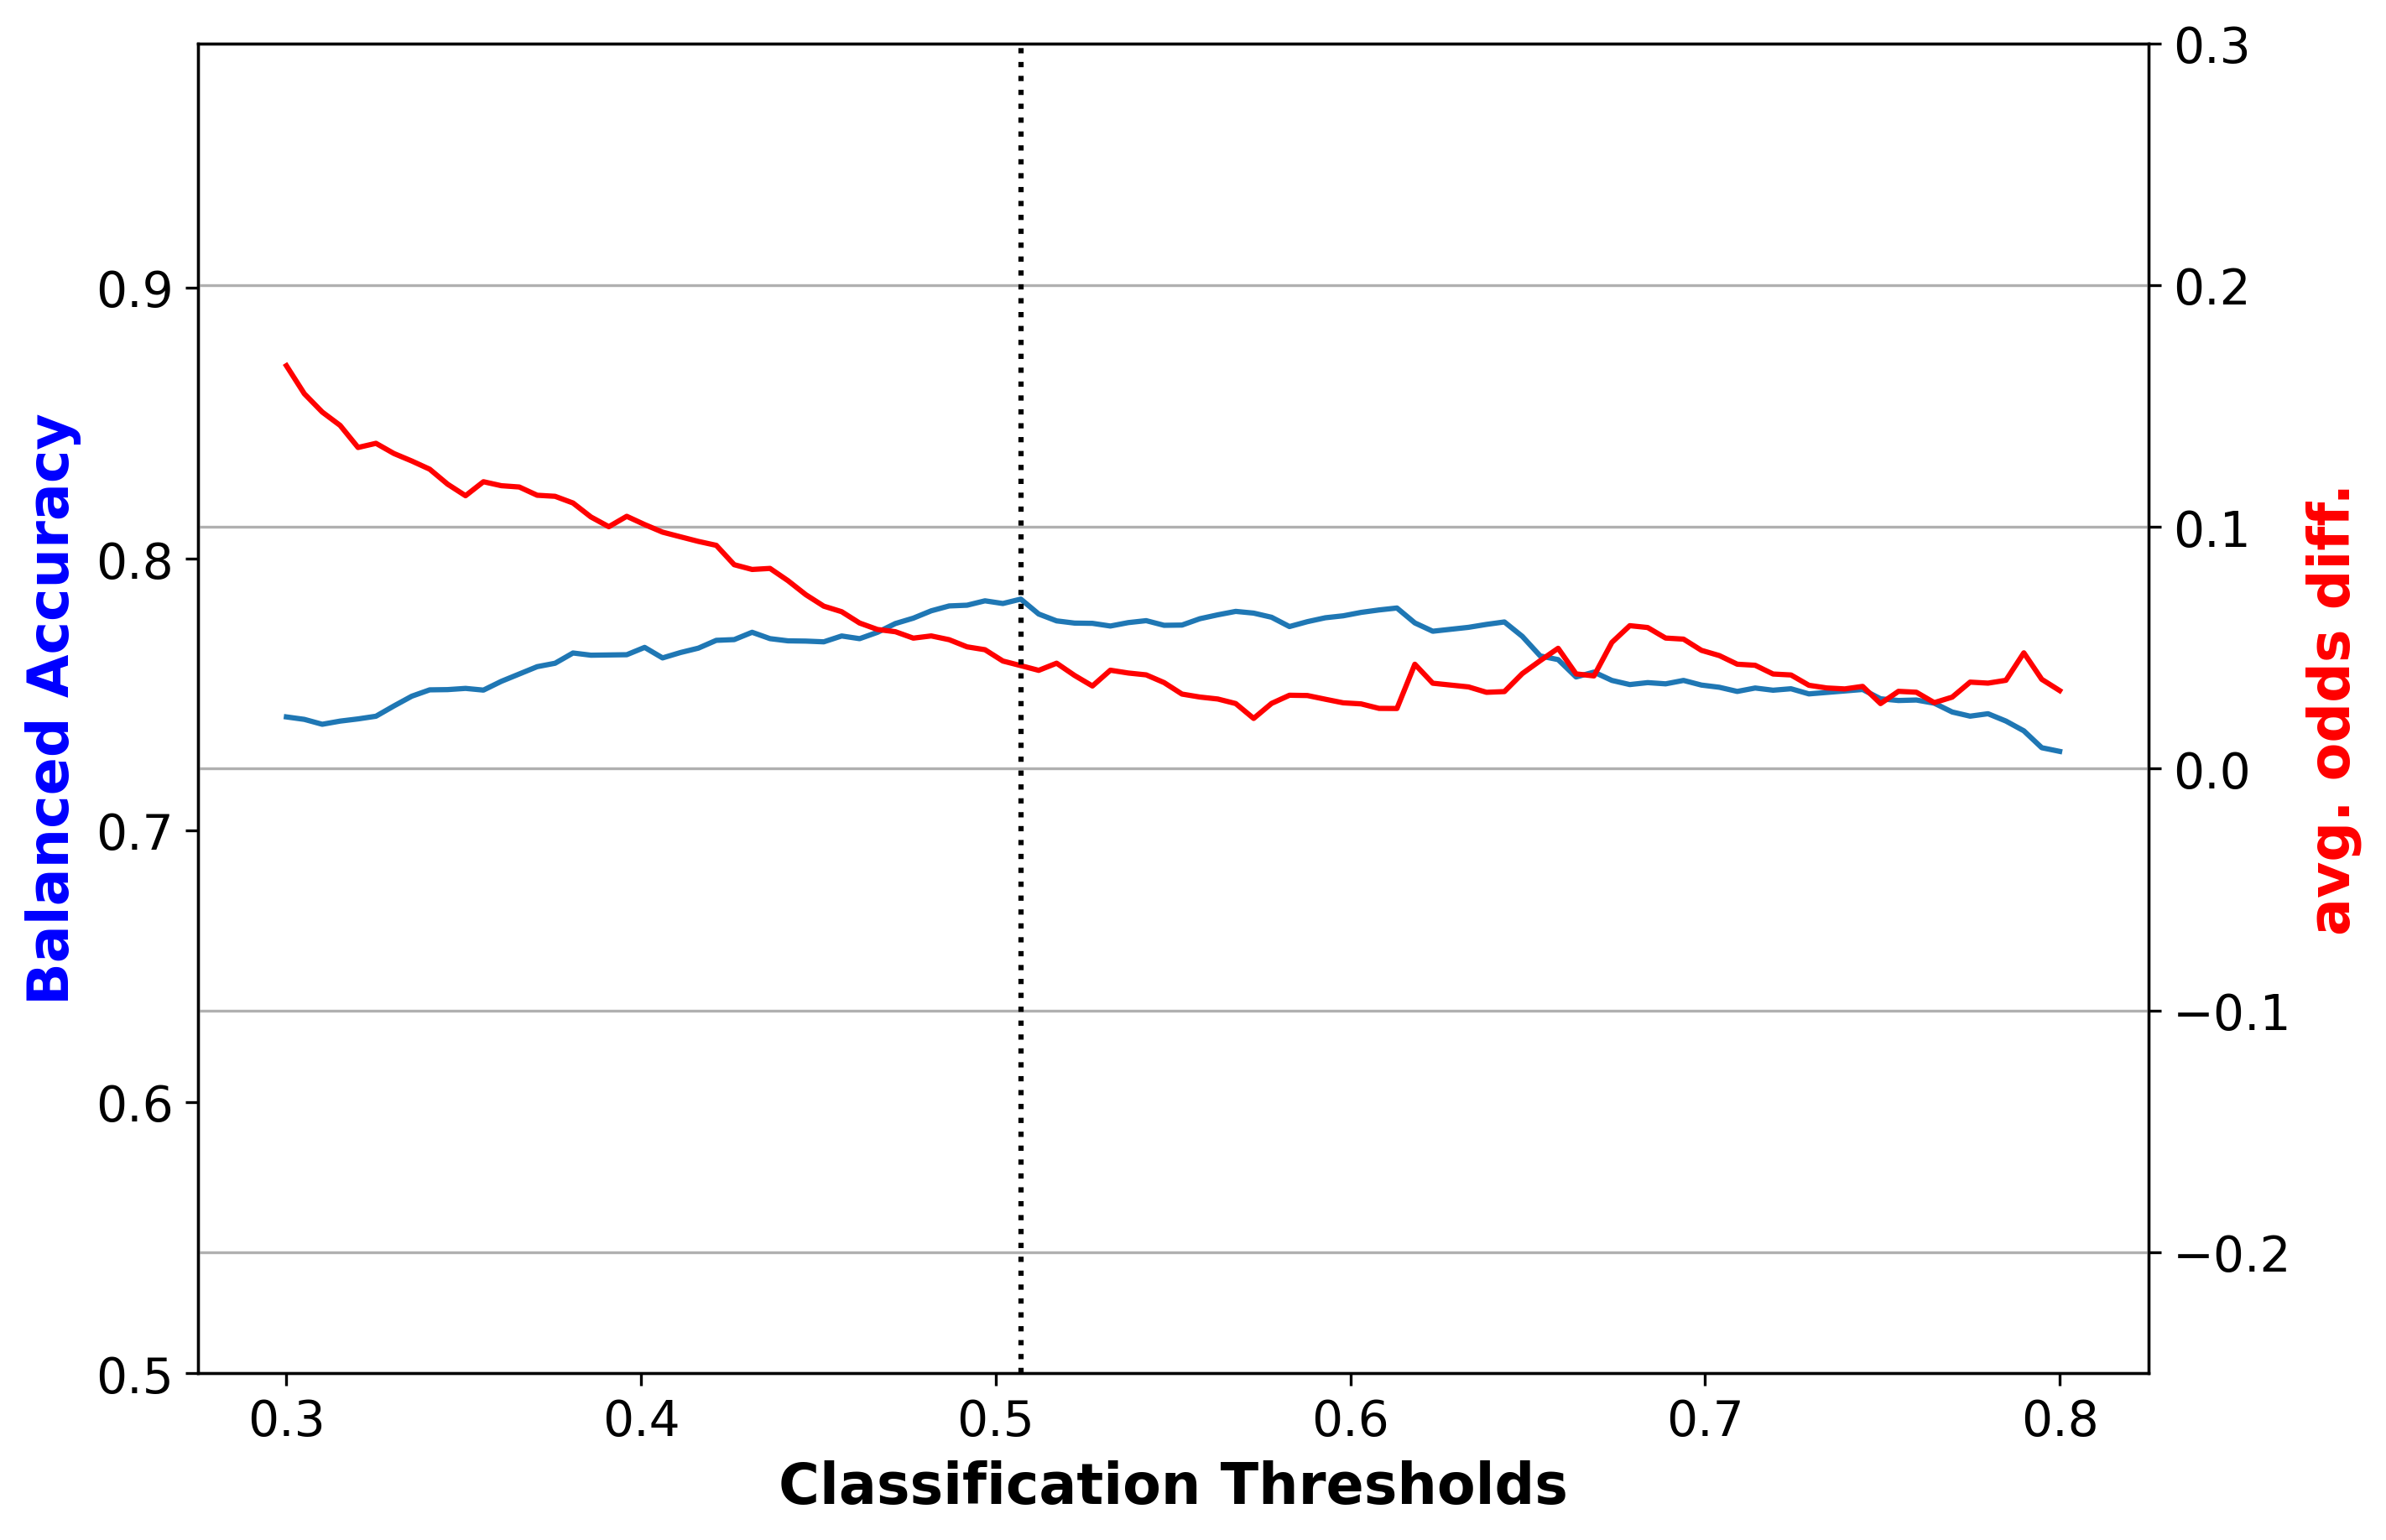

In [29]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [30]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.5071
Best balanced accuracy: 0.7852
Sensitivity: 0.7342
Specificity: 0.8362
Corresponding 1-min(DI, 1/DI) value: 0.4134
Corresponding average odds difference value: 0.0426
Corresponding statistical parity difference value: 0.1076
Corresponding equal opportunity difference value: -0.0051
Corresponding Theil index value: 0.0618


#### Testing RF model on original data

In [31]:
rf_orig_metrics = test(dataset=dataset_orig_test,
                       model=rf_orig,
                       thresh_arr=[thresh_arr[rf_orig_best_ind]])

In [32]:
describe_metrics(rf_orig_metrics, [thresh_arr[rf_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.5071
Best balanced accuracy: 0.7829
Sensitivity: 0.7731
Specificity: 0.7928
Corresponding 1-min(DI, 1/DI) value: 0.4367
Corresponding average odds difference value: 0.0822
Corresponding statistical parity difference value: 0.1412
Corresponding equal opportunity difference value: 0.0438
Corresponding Theil index value: 0.0663


As in the case of the logistic regression classifier learned on the original data, the fairness metrics for the random forest classifier have values that are quite far from 0.

For example, 1 - min(DI, 1/DI) has a value of over 0.4 as opposed to the desired value of < 0.2.

This indicates that the random forest classifier learned on the original data is also unfair.

## Bias mitigation using pre-processing technique - Reweighing

### Transform data

In [33]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(dataset_orig_train)

Metrics for transformed data

In [34]:
metric_transf_train = BinaryLabelDatasetMetric(
        dataset_transf_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_transf_train = MetricTextExplainer(metric_transf_train)

print(explainer_transf_train.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.0000000000000002


### Learning a Logistic Regression (LR) classifier on data transformed by reweighing

#### Training LR model after reweighing

In [35]:
dataset = dataset_transf_train
model = make_pipeline(MinMaxScaler(),
                      LogisticRegression(penalty='none'))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}
lr_transf = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

#### Validating  LR model after reweighing

In [36]:
thresh_arr = np.linspace(0.2, 0.9, 100)
val_metrics = test(dataset=dataset_orig_val,
                   model=lr_transf,
                   thresh_arr=thresh_arr)
lr_transf_best_ind = np.argmax(val_metrics['bal_acc'])

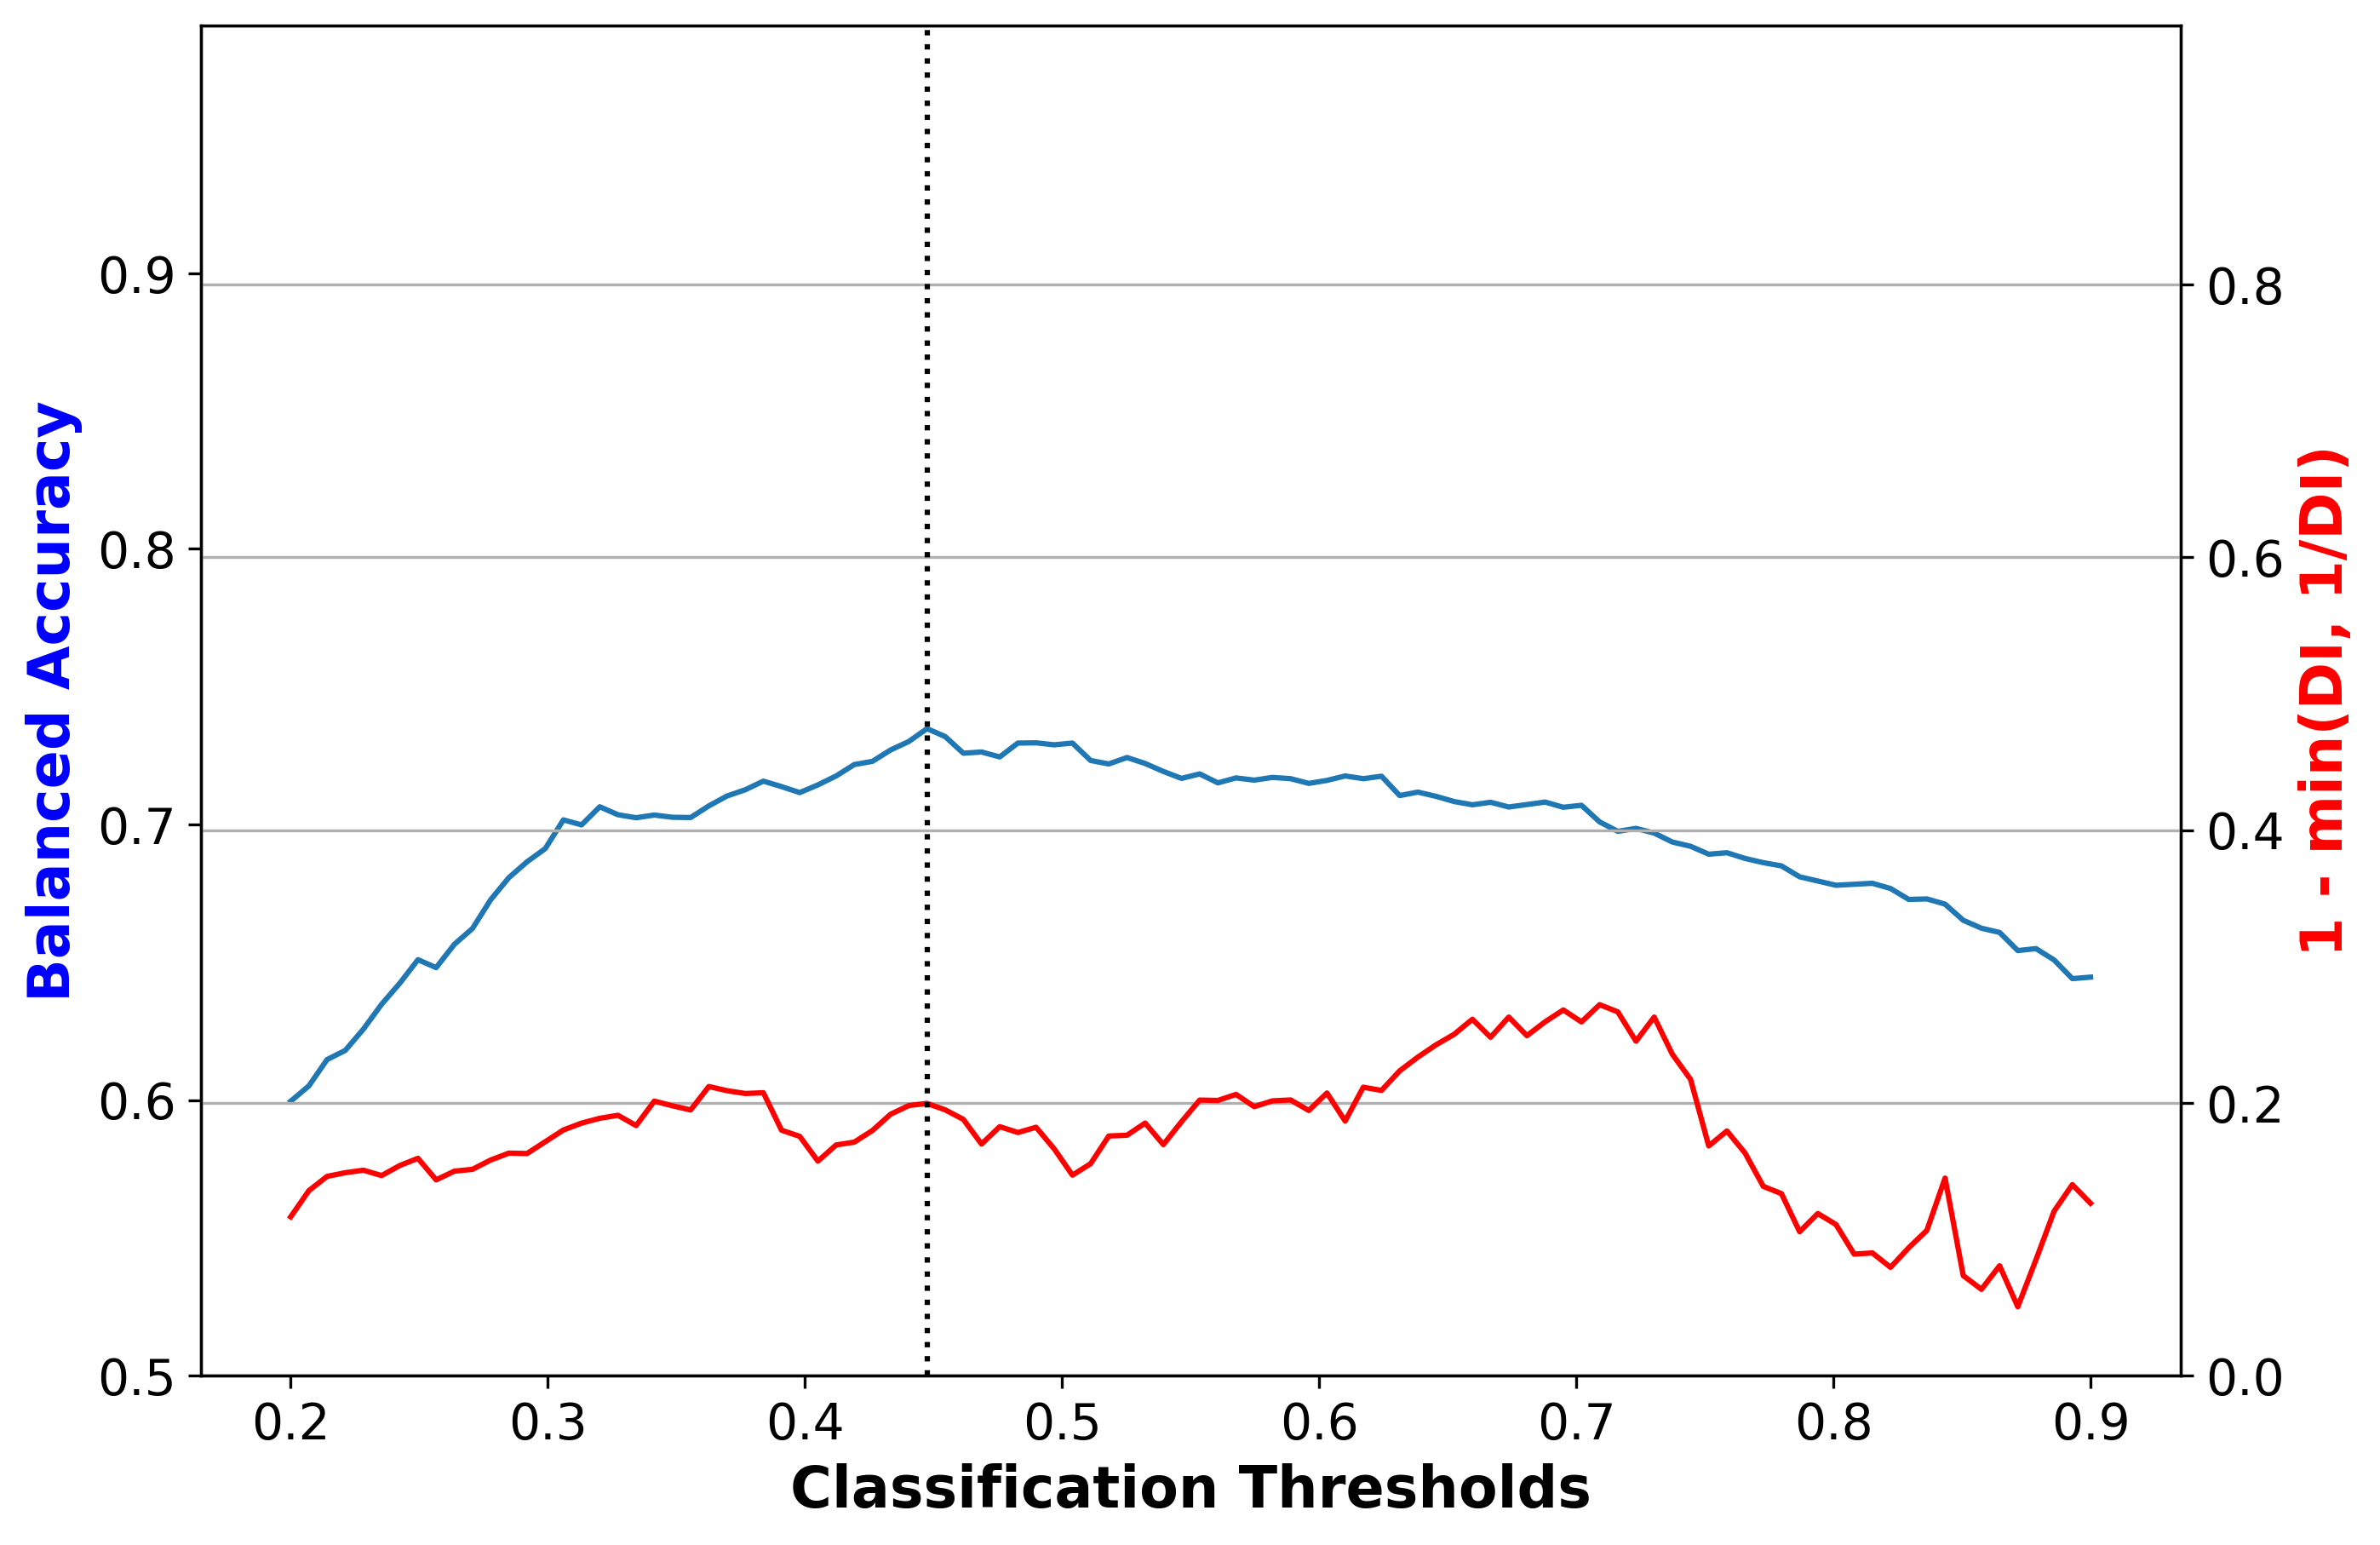

In [37]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

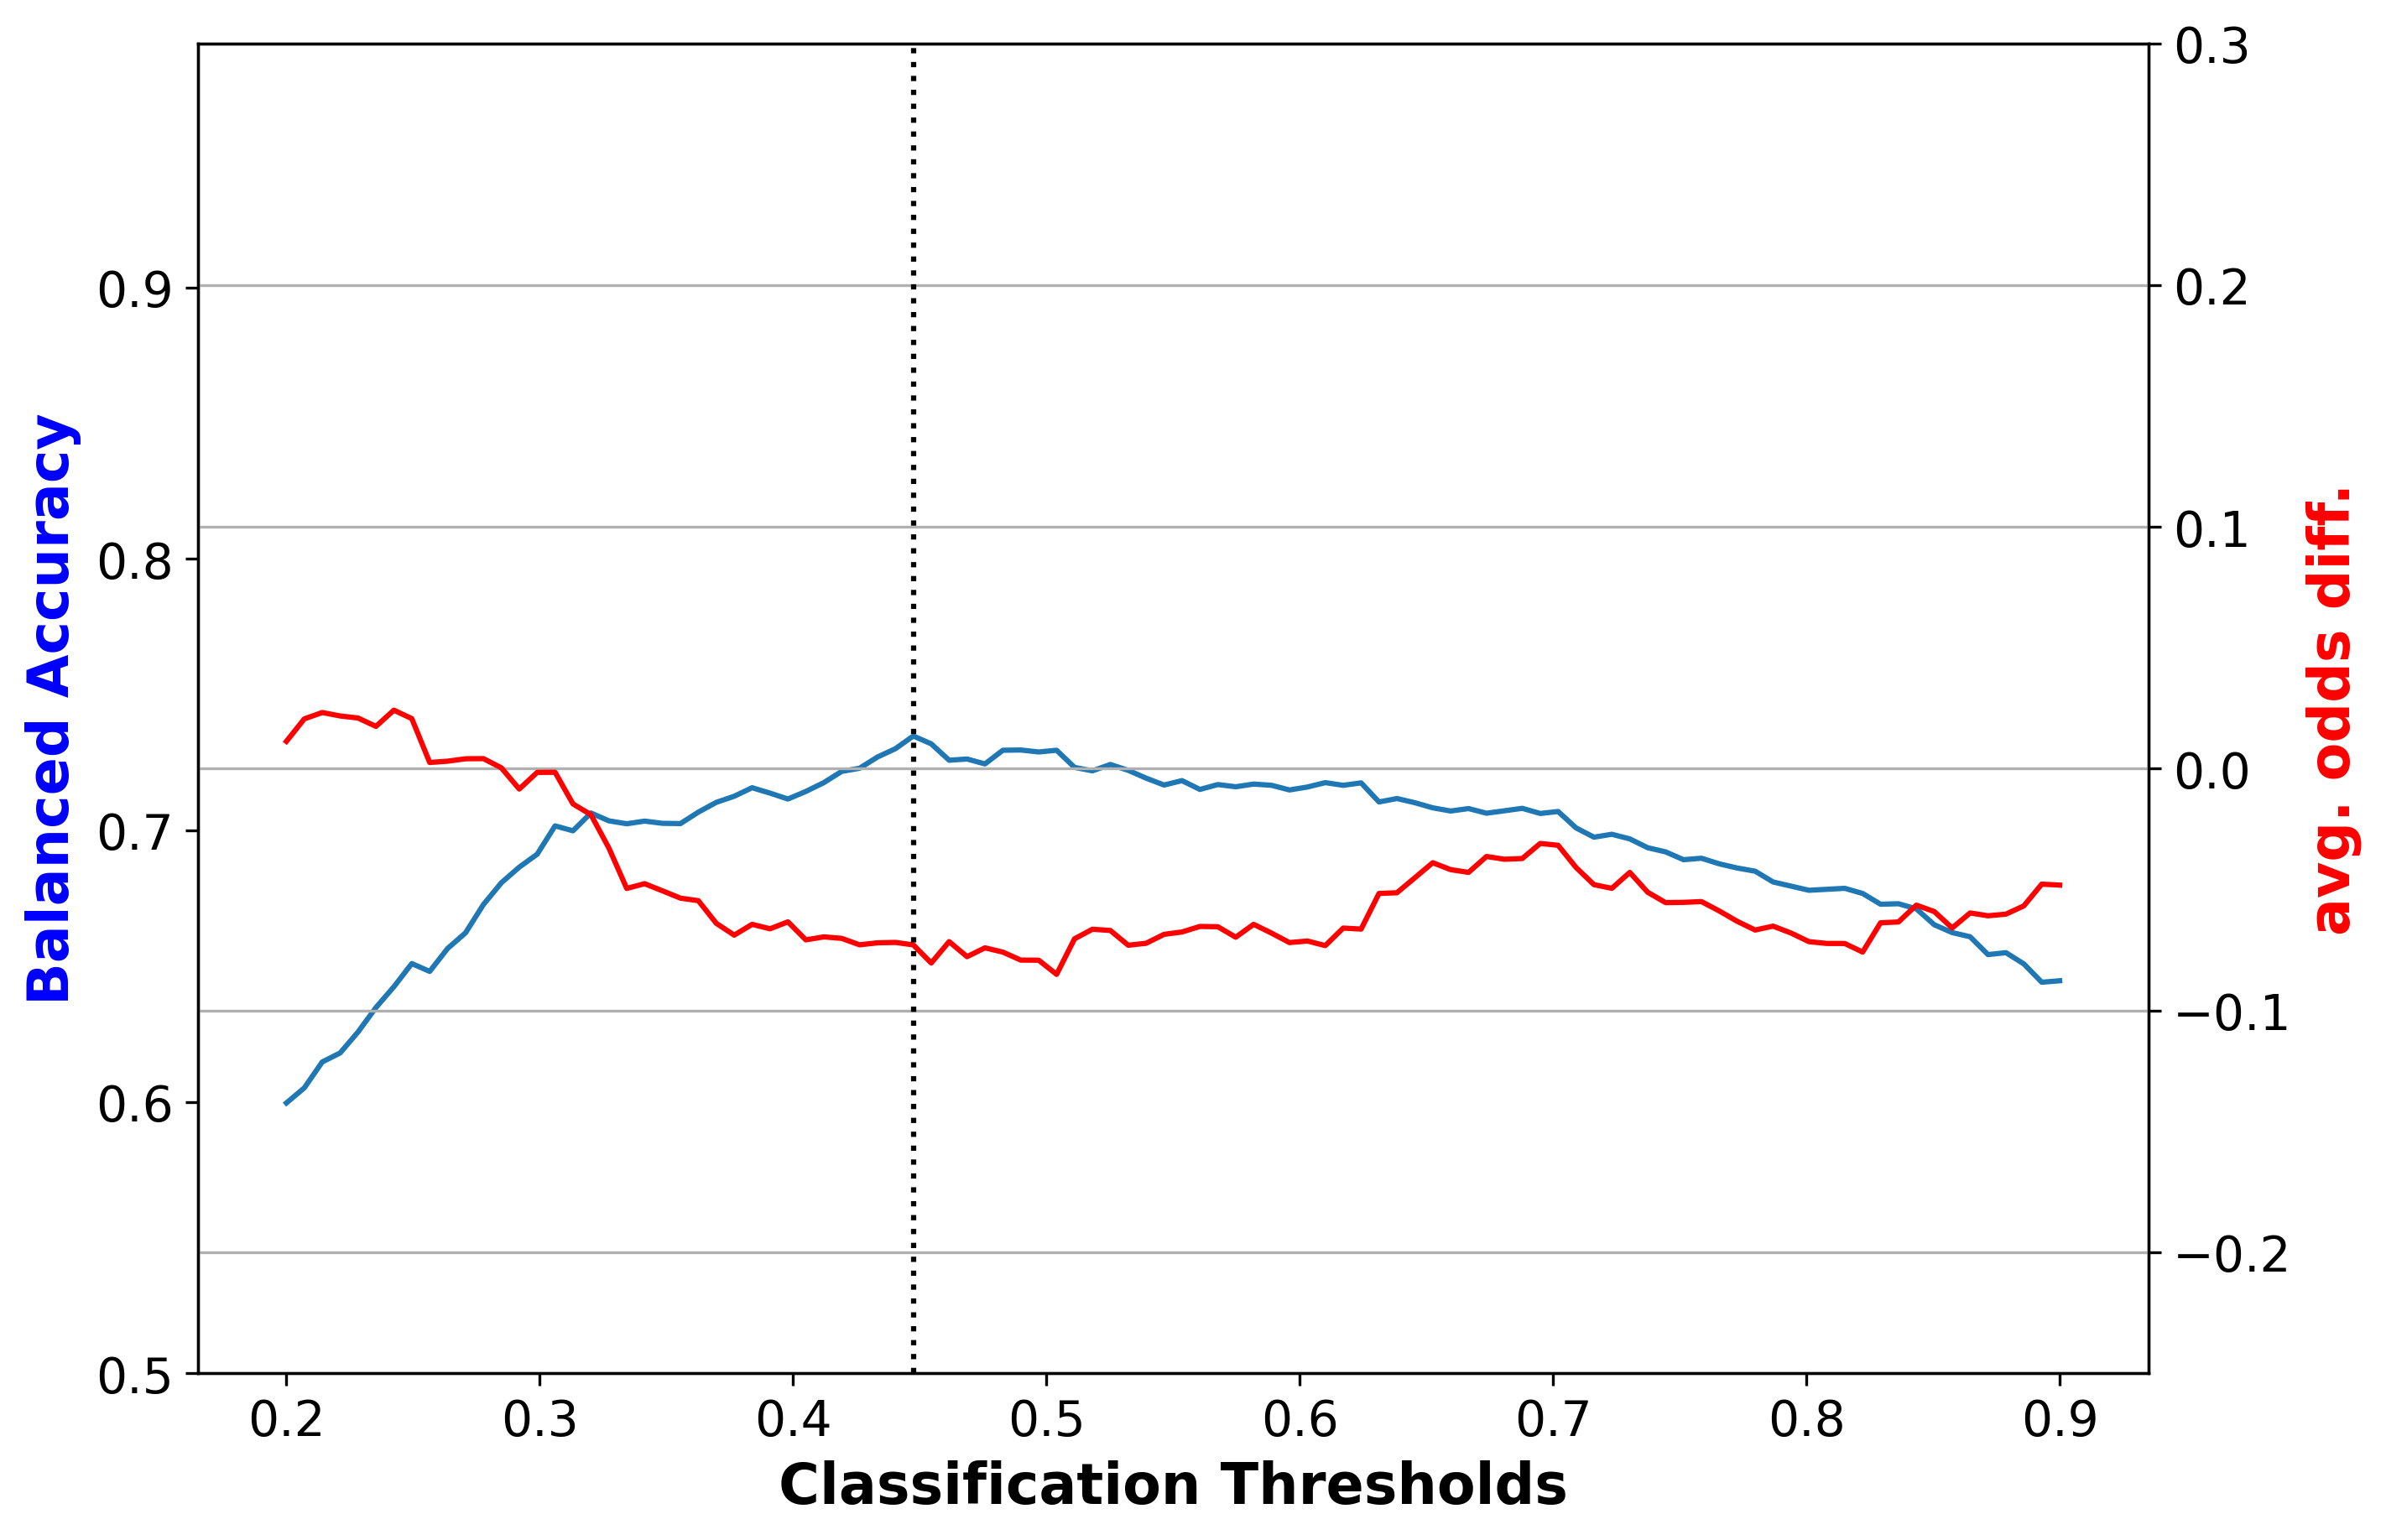

In [38]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [39]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.4475
Best balanced accuracy: 0.7348
Sensitivity: 0.6532
Specificity: 0.8164
Corresponding 1-min(DI, 1/DI) value: 0.1996
Corresponding average odds difference value: -0.0728
Corresponding statistical parity difference value: 0.0485
Corresponding equal opportunity difference value: -0.1905
Corresponding Theil index value: 0.0711


#### Testing  LR model after reweighing

In [40]:
lr_transf_metrics = test(dataset=dataset_orig_test,
                         model=lr_transf,
                         thresh_arr=[thresh_arr[lr_transf_best_ind]])

In [41]:
describe_metrics(lr_transf_metrics, [thresh_arr[lr_transf_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.4475
Best balanced accuracy: 0.7326
Sensitivity: 0.7357
Specificity: 0.7295
Corresponding 1-min(DI, 1/DI) value: 0.2476
Corresponding average odds difference value: 0.0389
Corresponding statistical parity difference value: 0.0870
Corresponding equal opportunity difference value: 0.0080
Corresponding Theil index value: 0.0759


The fairness metrics for the logistic regression model learned after reweighing are well improved, and thus the model is much more fair relative to the logistic regression model learned from the original data.

### Learning a Random Forest (RF) classifier on data transformed by reweighing

#### Training  RF model after reweighing

In [42]:
dataset = dataset_transf_train
model = make_pipeline(MinMaxScaler(),
                      RandomForestClassifier(n_estimators=500, min_samples_leaf=15))
fit_params = {'randomforestclassifier__sample_weight': dataset.instance_weights}
rf_transf = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

Save the fair model to disk

In [ ]:
from sklearn.externals import joblib
joblib.dump(rf_transf_panel19, 'rf.mod') 

#### Validating  RF model after reweighing

In [44]:
thresh_arr = np.linspace(0.2, 0.8, 100)
val_metrics = test(dataset=dataset_orig_val,
                   model=rf_transf,
                   thresh_arr=thresh_arr)
rf_transf_best_ind = np.argmax(val_metrics['bal_acc'])

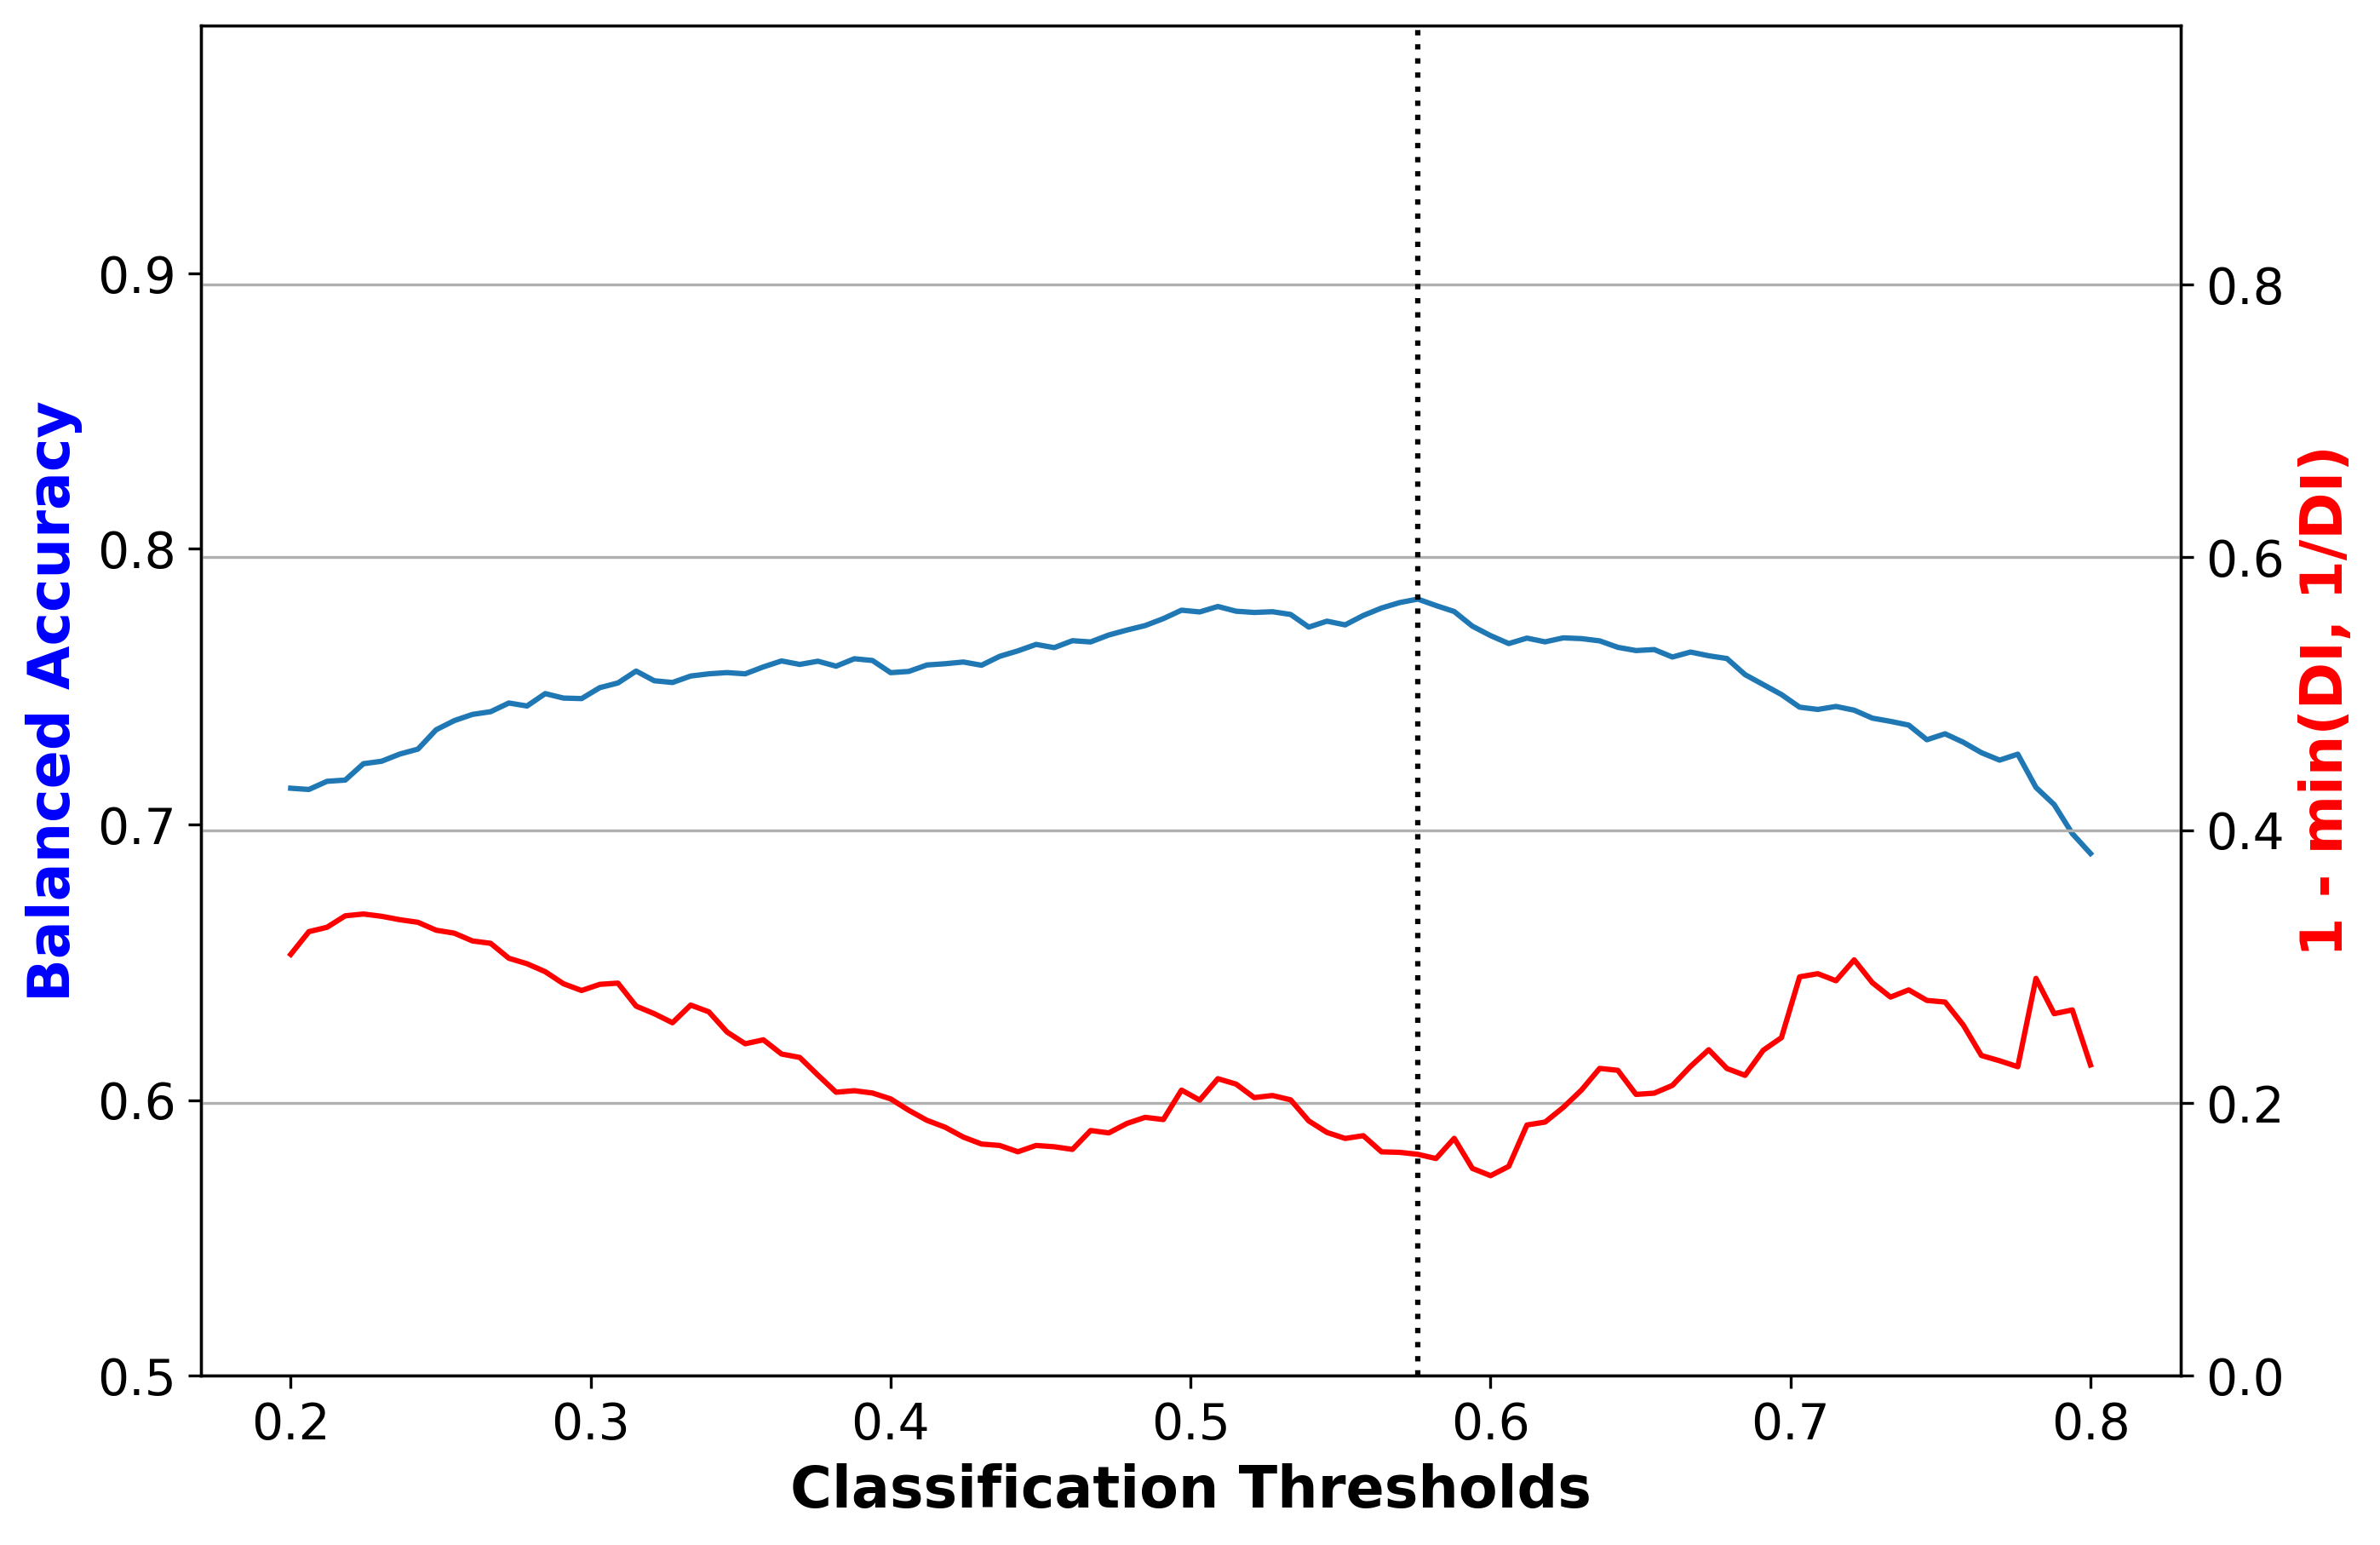

In [45]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

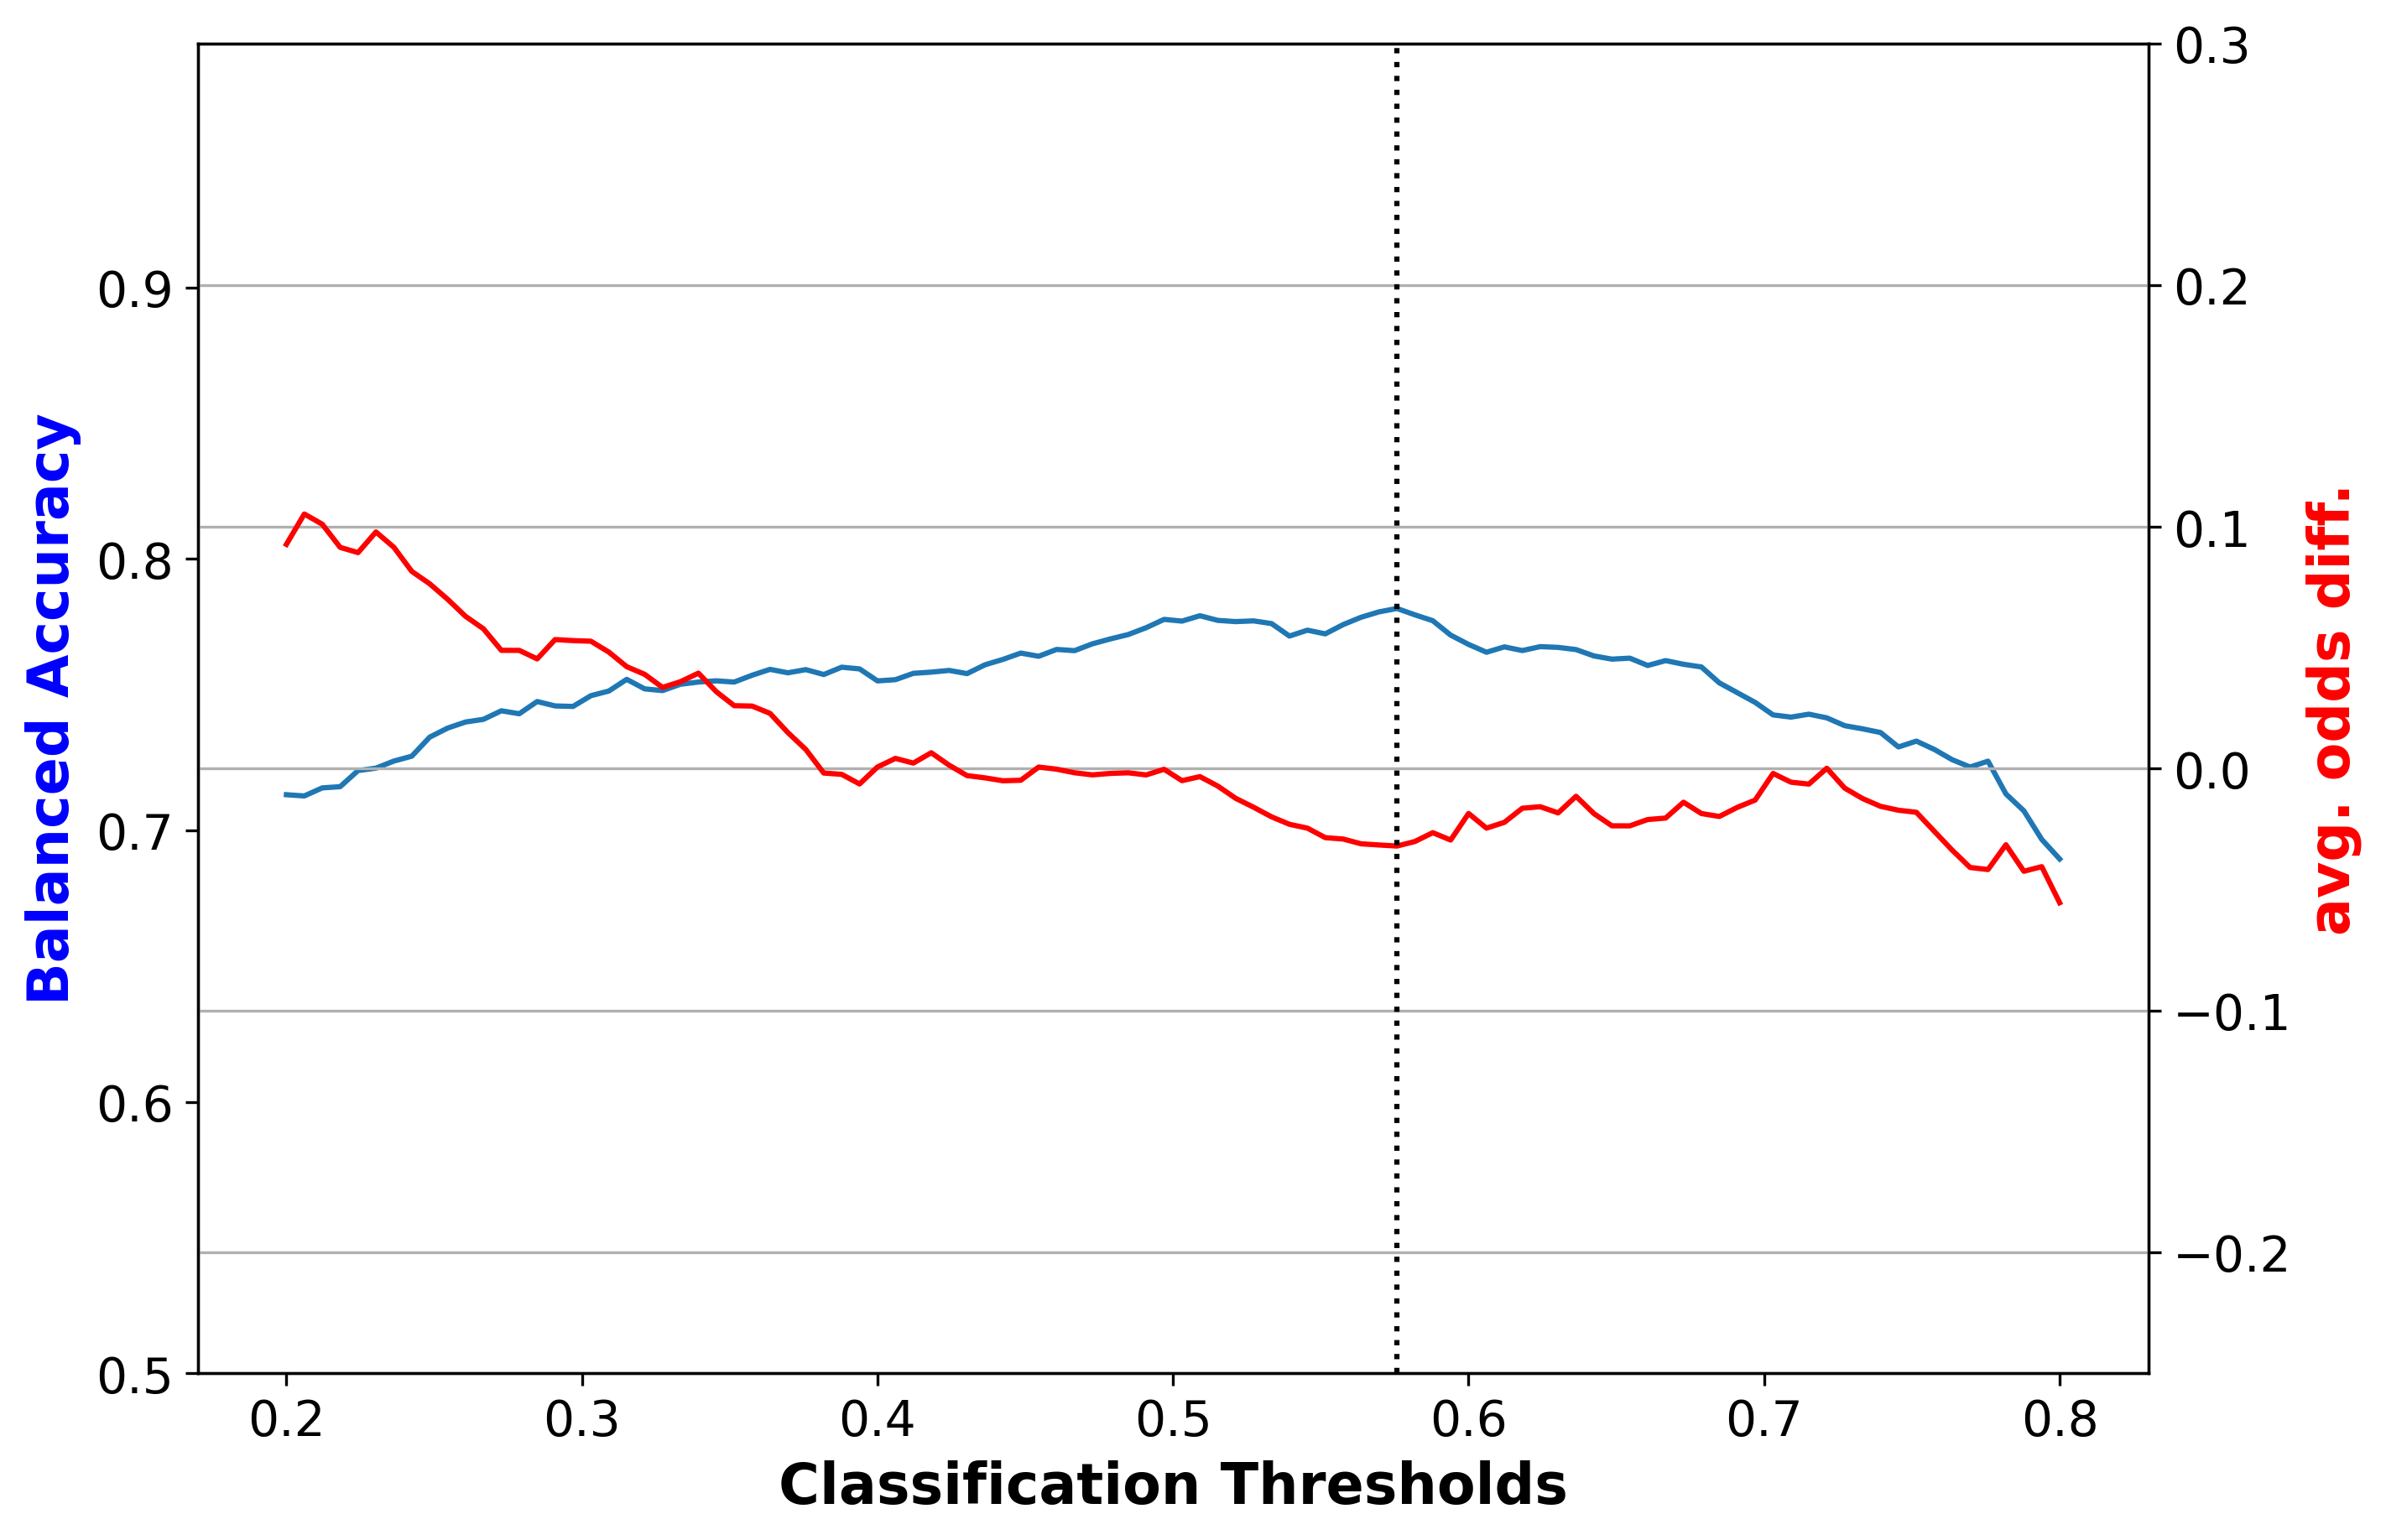

In [46]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [47]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.5758
Best balanced accuracy: 0.7818
Sensitivity: 0.6892
Specificity: 0.8744
Corresponding 1-min(DI, 1/DI) value: 0.1622
Corresponding average odds difference value: -0.0320
Corresponding statistical parity difference value: 0.0296
Corresponding equal opportunity difference value: -0.0755
Corresponding Theil index value: 0.0583


#### Testing  RF model after reweighing

In [48]:
rf_transf_metrics = test(dataset=dataset_orig_test,
                         model=rf_transf,
                         thresh_arr=[thresh_arr[rf_transf_best_ind]])

In [49]:
describe_metrics(rf_transf_metrics, [thresh_arr[rf_transf_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.5758
Best balanced accuracy: 0.7904
Sensitivity: 0.7357
Specificity: 0.8452
Corresponding 1-min(DI, 1/DI) value: 0.1784
Corresponding average odds difference value: -0.0152
Corresponding statistical parity difference value: 0.0394
Corresponding equal opportunity difference value: -0.0467
Corresponding Theil index value: 0.0617


Once again, the model learned from the transformed data is fairer than that learned from the original data.

Returning feature importance of fair model

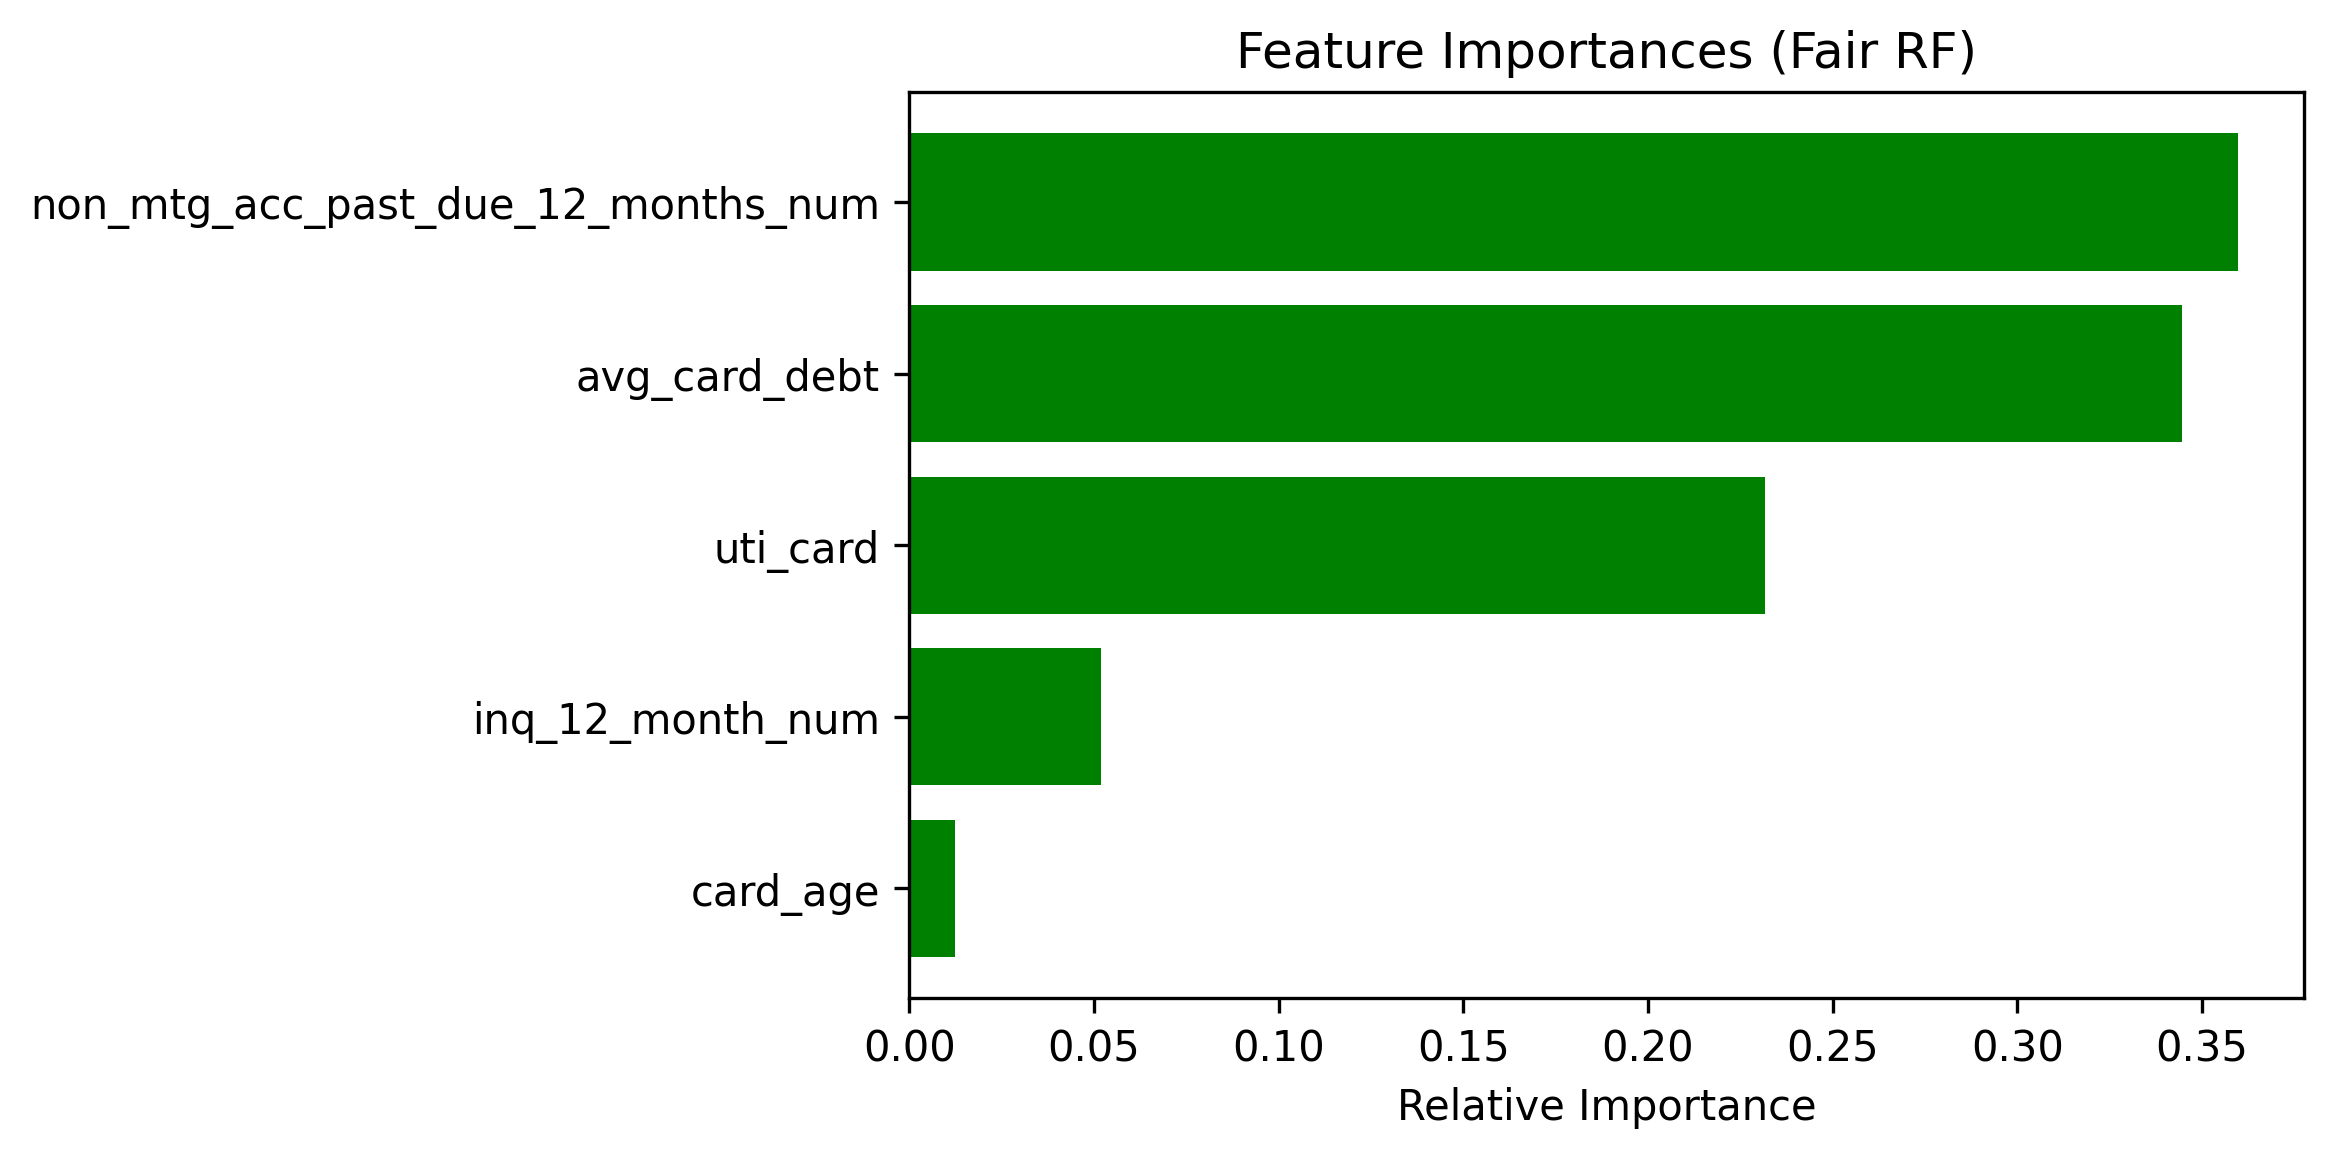

In [64]:
# Fair model
features = dataset.feature_names
importances = rf_transf.named_steps.randomforestclassifier.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances (Fair RF)')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Partial Dependence Plots for the Fair Model
If you want to see the PDP plots, run this part.  Otherwise you can skip it.  
(It takes some time to run...)

In [ ]:
from sklearn.inspection import plot_partial_dependence

# individual PDP plots
pdp_01 = plot_partial_dependence(rf_transf, dataset_orig_train.features, [0,1]) 
pdp_23 = plot_partial_dependence(rf_transf, dataset_orig_train.features, [2,3]) 
pdp_4 = plot_partial_dependence(rf_transf, dataset_orig_train.features, [4]) 

# paiwise PDP plots (it takes more time to run)
pdp_01 = plot_partial_dependence(rf_transf, dataset_orig_train.features, [(0,1)]) 
pdp_02 = plot_partial_dependence(rf_transf, dataset_orig_train.features, [(0,2)]) 
pdp_03 = plot_partial_dependence(rf_transf, dataset_orig_train.features, [(0,3)]) 
pdp_04 = plot_partial_dependence(rf_transf, dataset_orig_train.features, [(0,4)]) 
pdp_12 = plot_partial_dependence(rf_transf, dataset_orig_train.features, [(1,2)]) 
pdp_13 = plot_partial_dependence(rf_transf, dataset_orig_train.features, [(1,3)]) 
pdp_14 = plot_partial_dependence(rf_transf, dataset_orig_train.features, [(1,4)]) 
pdp_23 = plot_partial_dependence(rf_transf, dataset_orig_train.features, [(2,3)]) 
pdp_24 = plot_partial_dependence(rf_transf, dataset_orig_train.features, [(2,4)]) 
pdp_34 = plot_partial_dependence(rf_transf, dataset_orig_train.features, [(3,4)]) 

## Summary of Model Learning Results

In [50]:
import pandas as pd
pd.set_option('display.multi_sparse', False)
results = [lr_orig_metrics, rf_orig_metrics, lr_transf_metrics,
           rf_transf_metrics]
debias = pd.Series(['']*2 + ['Reweighing']*2,
                   name='Bias Mitigator')
clf = pd.Series(['Logistic Regression', 'Random Forest']*2,
                name='Classifier')
pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index([debias, clf])

,,bal_acc,sensitivity,specificity,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind
Bias Mitigator,Classifier,,,,,,,,
,Logistic Regression,0.712624,0.822943,0.602305,0.258381,2.402329,0.356183,0.164457,0.073901
,Random Forest,0.782924,0.773067,0.792781,0.082236,1.775409,0.141209,0.043781,0.066320
Reweighing,Logistic Regression,0.732584,0.735661,0.729506,0.038876,1.329019,0.086985,0.007965,0.075902
Reweighing,Random Forest,0.790422,0.735661,0.845184,-0.015168,1.217075,0.039445,-0.046727,0.061669


Of both models, the random forest model gives the best balance in terms of balanced accuracy and fairness. The logistic model is slightly unfair compared to the random forest model. Hence, we take the random forest model learnt from data transformed by re-weighing and 'deploy' it.


## Generating explanations for model predictions using LIME

### Generating explanations on the test data

This section shows how LIME can be integrated with AIF360 to get explanations for model predictions.

In [51]:
train_dataset = dataset_transf_train  # (rf from transformed data)
test_dataset = dataset_orig_test  # the data model is being tested on
model = rf_transf  # rf_transf_panel19 is RF model learned with Reweighing
thresh_arr = np.linspace(0.2, 0.8, 100)
best_thresh = thresh_arr[rf_transf_best_ind]

First, we need to fit the encoder to the aif360 dataset

In [52]:
lime_data = LimeEncoder().fit(train_dataset)

The `transform()` method is then used to convert aif360 features to LIME-compatible features

In [53]:
s_train = lime_data.transform(train_dataset.features)
s_test = lime_data.transform(test_dataset.features)

The `LimeTabularExplainer` takes as input the LIME-compatible data along with various other arguments to create a lime explainer.

In [59]:
explainer = LimeTabularExplainer(
        s_train, class_names=lime_data.s_class_names, 
        feature_names=lime_data.s_feature_names,
        categorical_features=lime_data.s_categorical_features, 
        categorical_names=lime_data.s_categorical_names, 
        kernel_width=3, verbose=False, discretize_continuous=True)

The `inverse_transform()` function is used to transform LIME-compatible data back to aif360-compatible data since that is needed by the model to make predictions. The function below is used to produce the predictions for any perturbed data that is produce by LIME.

In [60]:
def s_predict_fn(x):
    return model.predict_proba(lime_data.inverse_transform(x))

The `explain_instance()` method can then be used to produce explanations for any instance in the test dataset

In [61]:
def show_explanation(ind):
    exp = explainer.explain_instance(s_test[ind], s_predict_fn, num_features=5)
    print("Actual label: " + str(test_dataset.labels[ind]))
    exp.as_pyplot_figure()
    plt.title('Local Explanation for Class Rejected')
    plt.show()

In [62]:
exp = explainer.explain_instance(s_test[47], s_predict_fn, num_features=5)
exp.show_in_notebook(show_table=True)

Threshold corresponding to Best balanced accuracy: 0.5758
Actual label: [1.]


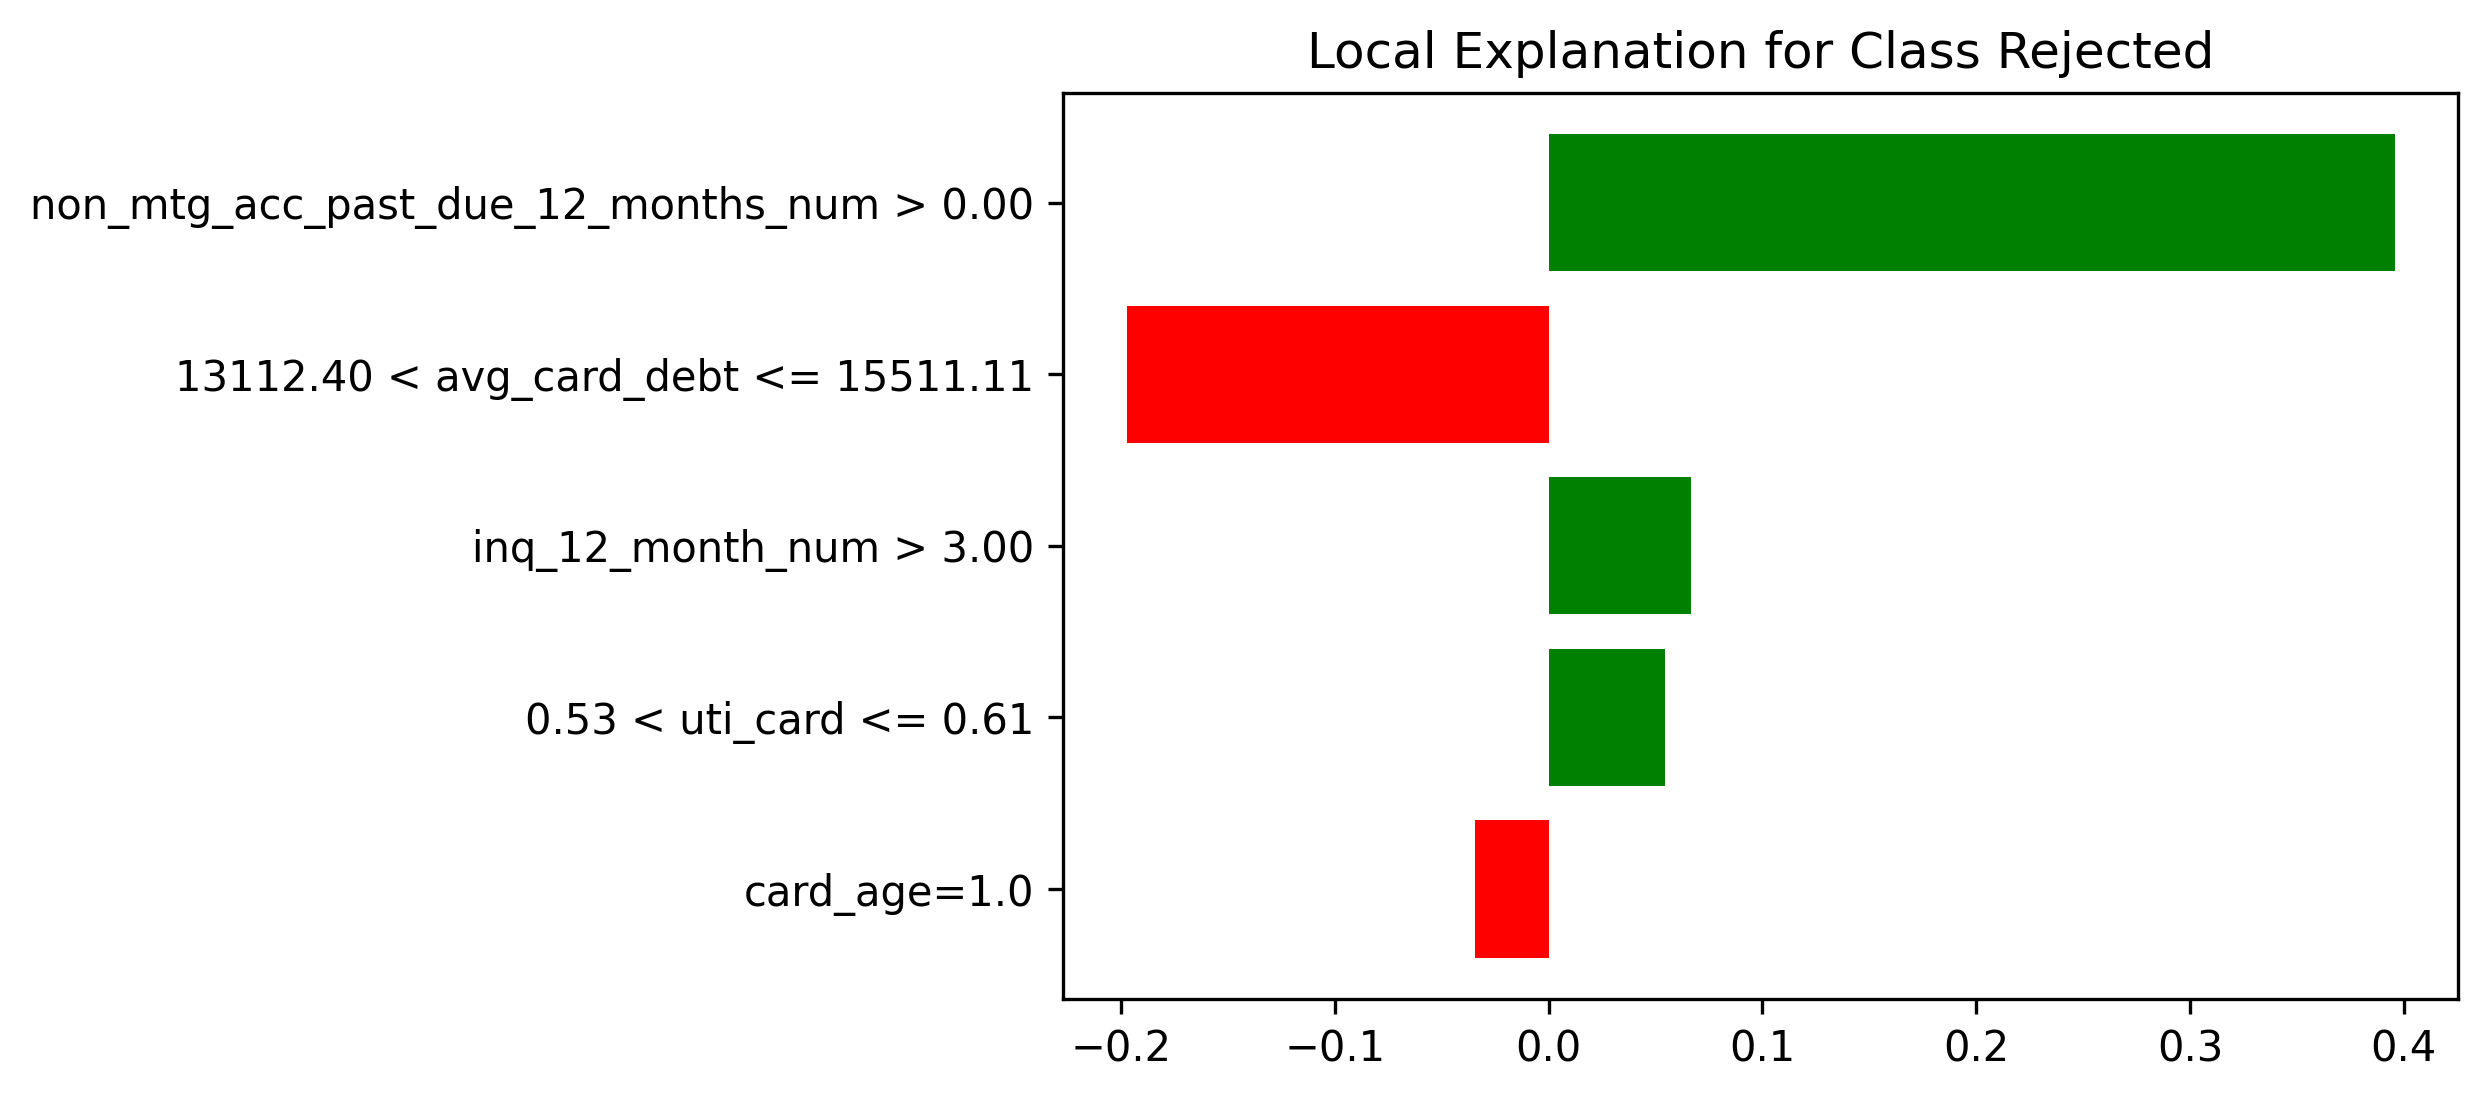

In [63]:
print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(best_thresh))
show_explanation(47)